In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import statsmodels.formula.api as smf
from scipy import stats

plt.style.use('seaborn-v0_8-poster')


In [2]:
def significance_marker(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""


def _draw_sig_line(ax, x1, x2, y, text, h=0.03):
    """Draw a flipped (downward) significance bracket below bars."""
    ax.plot((x1, x1, x2, x2),
            (y, y - h, y - h, y),
            lw=1.5, color="black", clip_on=False)
    if text:
        ax.text((x1 + x2) / 2.0, y - h * 1.2, text,
                ha="center", va="top",
                fontsize=14, fontweight="bold", color="black")


def get_matching_model_terms(model, variable):
    """
    Return model term names from model.params.index that match `variable`,
    excluding Group–Gender interactions.

    Behavior:
    ----------
    - If `variable` has no ':' or '*' → return only main-effect terms
      (e.g., 'Group' → ['Group[T.HC]'])
    - If `variable` includes ':' or '*' → return exact interaction terms
      (e.g., 'Group:Drug' → ['Group[T.HC]:Drug[T.Placebo]'])
    - If `variable` == 'two_way' → return *all* 2-way interactions
      (useful in 3-factor models like Group * Drug * Gender)
    - If `variable` == 'three_way' → return *all* 3-way interactions
    - Excludes Group–Gender interactions from all results.
    """

    # Remove intercept
    params = [p for p in model.params.index if p.lower() != "intercept"]

    # Helper: Exclude any Group–Gender interaction
    def is_group_gender_interaction(term):
        term_lower = term.lower()
        return "group" in term_lower and "gender" in term_lower

    # === Case 1: Request all 2-way interactions ===
    if variable.lower() == "two_way":
        return [p for p in params if p.count(":") == 1 and not is_group_gender_interaction(p)]

    # === Case 2: Request all 3-way interactions ===
    if variable.lower() == "three_way":
        return [p for p in params if p.count(":") == 2 and not is_group_gender_interaction(p)]

    # === Case 3: Single factor → main effects only ===
    if (":" not in variable) and ("*" not in variable):
        factor = variable
        return [p for p in params if p.startswith(factor + "[") and (":" not in p)]

    # === Case 4: Specific interaction (2-way or 3-way) ===
    var = variable.replace("*", ":")
    factors = [f for f in var.split(":") if f]

    out = []
    for p in params:
        # must have correct interaction order
        if p.count(":") != (len(factors) - 1):
            continue
        # must include all specified factors
        if all((f + "[") in p for f in factors):
            # exclude Group–Gender interactions
            if not is_group_gender_interaction(p):
                out.append(p)

    return out




def extract_factors_from_term(term):
    """
    Extract base factor names (e.g., 'Group', 'Drug', 'Gender') 
    from a statsmodels term like:
        'Group[T.HC]:Drug[T.Placebo]'  → ['Group', 'Drug']
        'Group[T.HC]:Drug[T.Placebo]:Gender[T.Female]' → ['Group', 'Drug', 'Gender']
        'Group[T.HC]' → ['Group']

    Works for both main and interaction terms.
    """
    # Split by ':' to separate interaction components
    parts = term.split(":")
    # For each part, take everything before the first '['
    factors = [p.split("[")[0] for p in parts]
    return factors

In [3]:
def add_sig_stars(ax, df, roi_list, variable, pad_frac=0.1, hue_order=None):
    """
    Generalized version that supports 2-way, 3-way, or higher-order interactions.

    Prints:
      1. Model result (ROI, variable, β, t, df, p)
      2. One-sample t-tests (ROI, factor level, mean, t, df, p)
    Adds * to bar plot for significant results.

    Automatically reads model factors from 'variable'.
    e.g. variable='Group[T.HC]:Drug[T.Placebo]:Gender[T.Female]' → model='Z_score ~ Group * Drug * Gender'
    """

    ymin, ymax = ax.get_ylim()
    y_range = ymax - ymin
    is_interaction = ":" in variable

    # === Parse model factors dynamically ===
    # Example: 'Group[T.HC]:Drug[T.Placebo]:Gender[T.Female]' → ['Group', 'Drug', 'Gender']
    factors = list(dict.fromkeys([term.split("[")[0] for term in variable.split(":")]))
    formula = "Z_score ~ " + " * ".join(factors) + ("" if "guess" in factors else " + guess")


    print(f"\nModel results ({formula})")
    print(f"{'ROI':<15} {'Variable':<50} {'β':>10} {'t':>8} {'df':>5} {'p':>8} {'Sig':>5}")
    print("-" * 100)

    # === Table 1: Model results ===
    for i, roi in enumerate(roi_list):
        df_roi = df[df["ROI"] == roi]
        if len(df_roi) < 4:
            continue

        # 🔹 Dynamically specified model
        model = smf.ols(formula, data=df_roi).fit()

        if variable not in model.params.index:
            continue

        beta = model.params[variable]
        tval = model.tvalues[variable]
        pval = model.pvalues[variable]
        dfree = int(model.df_resid)
        star = significance_marker(pval)

        print(f"{roi:<15} {variable:<50} {beta:>10.3f} {tval:>8.2f} {dfree:>5} {pval:>8.3f} {star:>5}")

        # --- Bar selection per ROI ---
        bars = [r for r in ax.patches if abs((r.get_x() + r.get_width() / 2) - i) < 0.45]
        if not bars:
            continue

        # --- Draw flipped bracket for significant model effects (main effects only) ---
        if not is_interaction and star:
            bars_sorted = sorted(bars, key=lambda r: r.get_x())
            b1, b2 = bars_sorted[0], bars_sorted[-1]
            x1c = b1.get_x() + b1.get_width() / 2
            x2c = b2.get_x() + b2.get_width() / 2
            x_mid = (x1c + x2c) / 2
            y1 = b1.get_y() + b1.get_height()
            y2 = b2.get_y() + b2.get_height()
            min_y = min(y1, y2)
            y_bracket = min_y - 0.3
            y_star = min_y - 0.4
            _draw_sig_line(ax, x1c, x2c, y_bracket, "", h=y_range * 0.03)
            ax.text(x_mid, y_star, star,
                    ha="center", va="top",
                    fontsize=14, fontweight="bold", color="black")

    print("-" * 100)

    # === Table 2: One-sample t-tests ===
    if is_interaction:
        group_factors = factors
        print(f"ONE-SAMPLE T-TESTS BY INTERACTION LEVEL ({' × '.join(group_factors)})")
    else:
        group_factors = [factors[0]]
        print(f"ONE-SAMPLE T-TESTS BY {group_factors[0].upper()} LEVEL")

    print(f"{'ROI':<15} {'Level':<50} {'Mean':>10} {'t':>8} {'df':>6} {'p':>10} {'Sig':>5}")
    print("-" * 100)

    for i, roi in enumerate(roi_list):
        df_roi = df[df["ROI"] == roi]
        if len(df_roi) < 4:
            continue

        bars = [r for r in ax.patches if abs((r.get_x() + r.get_width() / 2) - i) < 0.45]

        # === Main effect ===
        if len(group_factors) == 1:
            factor = group_factors[0]
            if factor not in df_roi.columns:
                continue

            for level, vals in df_roi.groupby(factor, observed=False):
                if len(vals) < 3:
                    continue
                tstat, pval = stats.ttest_1samp(vals["Z_score"], 0)
                dfree = len(vals) - 1
                mean_val = np.mean(vals["Z_score"])
                star = significance_marker(pval)
                label = f"{factor}={level}"
                print(f"{roi:<15} {label:<50} {mean_val:>10.3f} {tstat:>8.2f} {dfree:>6} {pval:>10.3f} {star:>5}")

                if star:
                    if hue_order is None:
                        hue_order = list(df[factor].cat.categories)
                    level_to_bar = dict(zip(hue_order, bars))
                    if level in level_to_bar:
                        rect = level_to_bar[level]
                        cx = rect.get_x() + rect.get_width() / 2
                        top = rect.get_y() + rect.get_height()
                        y_star = 0.04 if mean_val <= 0 else top + y_range * pad_frac + 0.2
                        ax.text(cx, y_star, star,
                                ha="center", va="bottom",
                                fontsize=14, fontweight="bold", color="black")

        # === Interaction effect (2-way, 3-way, or higher) ===
        else:
            valid_factors = [f for f in group_factors if f in df_roi.columns]
            if len(valid_factors) < 2:
                continue

            for levels, vals in df_roi.groupby(valid_factors, observed=False):
                if len(vals) < 3:
                    continue
                tstat, pval = stats.ttest_1samp(vals["Z_score"], 0)
                dfree = len(vals) - 1
                mean_val = np.mean(vals["Z_score"])
                star = significance_marker(pval)
                level_labels = "_".join(map(str, levels))
                print(f"{roi:<15} {level_labels:<50} {mean_val:>10.3f} "
                      f"{tstat:>8.2f} {dfree:>6} {pval:>10.3f} {star:>5}")

                if star:
                    # Build hue order dynamically based on unique combinations
                    if hue_order is None:
                        hue_order = [
                            "_".join(map(str, combo))
                            for combo in df_roi[valid_factors]
                            .drop_duplicates()
                            .itertuples(index=False, name=None)
                        ]
                    level_to_bar = dict(zip(hue_order, bars))
                    key = "_".join(map(str, levels))
                    if key in level_to_bar:
                        rect = level_to_bar[key]
                        cx = rect.get_x() + rect.get_width() / 2
                        top = rect.get_y() + rect.get_height()
                        y_star = 0.04 if mean_val <= 0 else top + y_range * pad_frac + 0.2
                        ax.text(cx, y_star, star,
                                ha="center", va="bottom",
                                fontsize=14, fontweight="bold", color="black")

    print("-" * 100)


In [4]:
def add_sig_stars_lineplot_interaction(ax, df, roi_list, variable):
    """
    Adds significance stars (***, **, *) to each subplot's title
    if the specified interaction term in `variable` is significant
    for that ROI.

    Automatically supports 2-way, 3-way, or higher-order interactions.
    e.g.:
        'Group[T.HC]:Gender[T.Female]'
        'Group[T.HC]:Drug[T.Placebo]:Gender[T.Female]'
    """

    # Extract main factors from variable (remove duplicates safely)
    factors = list(dict.fromkeys([term.split("[")[0] for term in variable.split(":")]))
    formula = "Z_score ~ " + " * ".join(factors) + ("" if "guess" in factors else " + guess")

    axes = ax.flat if hasattr(ax, "flat") else [ax]

    print(f"\n=== Lineplot significance check for {variable} ===")
    print(f"Model formula: {formula}")
    print(f"{'ROI':<15} {'p-value':>10} {'Sig':>5}")
    print("-" * 35)

    for i, roi in enumerate(roi_list):
        if i >= len(axes):
            break
        ax_i = axes[i]

        df_roi = df[df["ROI"] == roi]
        if len(df_roi) < 4:
            continue

        # Dynamically fit model with all relevant factors
        model = smf.ols(formula, data=df_roi).fit()

        # Skip if the term is not part of the model
        if variable not in model.pvalues.index:
            continue

        # Get p-value and significance marker
        pval = model.pvalues[variable]
        star = significance_marker(pval)

        # Update subplot title with star if significant
        current_title = ax_i.get_title()
        new_title = f"{current_title} {star}" if star else current_title
        ax_i.set_title(new_title, fontweight="bold" if star else "normal")

        print(f"{roi:<15} {pval:>10.4f} {star:>5}")

    print("-" * 35)


In [11]:
tasks = ['phase2','phase3']
contrast_list = [
        "CSR-CSS",   
        "CSR-CS-",
        "CSS-CS-",
        "CSR-fix", 
        "CSS-fix",   
        "CSminus-fix"
        ]
ROI_list = [
        'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
        'VMPFC'
        ]
group_list = [
        'Patient',
        'HC'
        ]
drug_list = ['Oxytocin',
        'Placebo']
gender_list = ['Male', 'Female']
guess_list = ['no', 'yes']

In [6]:
plot_dir_top = '/Users/xiaoqianxiao/Projects/NARSAD/MRI/derivatives/fMRI_analysis/ROI/plots/model-guess-noGroupGenderInteraction_motion-ori'
drug_order_file = '/Users/xiaoqianxiao/Projects/NARSAD/MRI/source_data/behav/drug_order.xlsx'
df_drug_order = pd.read_excel(drug_order_file, 'drug_order')
first_level_dir = '/Users/xiaoqianxiao/Projects/NARSAD/MRI/derivatives/fMRI_analysis/ROI'
first_level_data_file = os.path.join(first_level_dir, 'first_level.csv')
df_fMRI = pd.read_csv(first_level_data_file)
df_merged = pd.merge(df_fMRI, df_drug_order, on='subID', how='left')
df_all = df_merged.rename(columns={
    'Task': 'Phase'
})
df_all.loc[df_all['subID'].str.startswith('N1'), 'Group'] = 'Patient'
df_all.loc[df_all['subID'].str.startswith('N2'), 'Group'] = 'HC'
categorical_cols = ['ROI', 'subID', 'Phase', 'Contrast', 'Group', 'Gender', 'Drug','guess']
df_all[categorical_cols] = df_all[categorical_cols].astype('category')
df_all['Contrast'] = df_all['Contrast'].cat.set_categories(contrast_list, ordered=True)
df_all['ROI'] = df_all['ROI'].cat.set_categories(ROI_list, ordered=True)
df_all['Group'] = df_all['Group'].cat.set_categories(group_list, ordered=True)
df_all['Drug'] = df_all['Drug'].cat.set_categories(drug_list, ordered=True)
df_all['Gender'] = df_all['Gender'].cat.set_categories(gender_list, ordered=True)
df_all['guess'] = df_all['guess'].map({0.0: 'no', 1.0: 'yes'})
df_all['guess'] = pd.Categorical(df_all['guess'], categories=['no', 'yes'])


In [7]:
print(len(df_fMRI.loc[df_fMRI['Task']=='phase2']['subID'].unique()))
print(len(df_fMRI.loc[df_fMRI['Task']=='phase3']['subID'].unique()))
print(len(df_drug_order['subID'].unique()))

100
101
104


In [8]:
# Subjects in drug order but missing from fMRI data
missing_in_fMRI = df_drug_order.loc[
    ~df_drug_order['subID'].isin(df_fMRI.loc[df_fMRI['Task']=='phase2']['subID']), 'subID'
].unique()

print(f"🧩 Subjects in drug order file but not in fMRI data in phase2: {len(missing_in_fMRI)}")
print(missing_in_fMRI)

missing_in_fMRI = df_drug_order.loc[
    ~df_drug_order['subID'].isin(df_fMRI.loc[df_fMRI['Task']=='phase3']['subID']), 'subID'
].unique()

print(f"🧩 Subjects in drug order file but not in fMRI data in phase3: {len(missing_in_fMRI)}")
print(missing_in_fMRI)
# SUBJECTS_NO_MRI = {
#     'phase2': ['N102', 'N208'],
#     'phase3': ['N102', 'N208', 'N120']
# }
# removing subjects w wrong sequence / missing phases:
# sub101 has 2mm seq for phase 2, 3mm (correct) for phase 3
# sub201, has 2mm seq for phase 2, 3mm (correct) for phase 3



🧩 Subjects in drug order file but not in fMRI data in phase2: 4
['N101' 'N102' 'N201' 'N208']
🧩 Subjects in drug order file but not in fMRI data in phase3: 3
['N102' 'N120' 'N208']


Extinction

placebo 

In [9]:
plot_dir = os.path.join(plot_dir_top, 'extinction/placebo')
os.makedirs(plot_dir, exist_ok=True)
model = smf.ols("Z_score ~ Group * Gender + guess", data=df_all).fit()


===== Group main effect: CSR-CSS =====

Model results (Z_score ~ guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        guess[T.yes]                                           -0.172    -0.71    98    0.478      
Insula          guess[T.yes]                                            0.070     0.27    98    0.788      
Hippocampus     guess[T.yes]                                           -0.010    -0.04    98    0.970      
ACC             guess[T.yes]                                            0.107     0.41    98    0.682      
VMPFC           guess[T.yes]                                           -0.112    -0.40    98    0.692      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GUESS LEVEL
ROI             Level                      

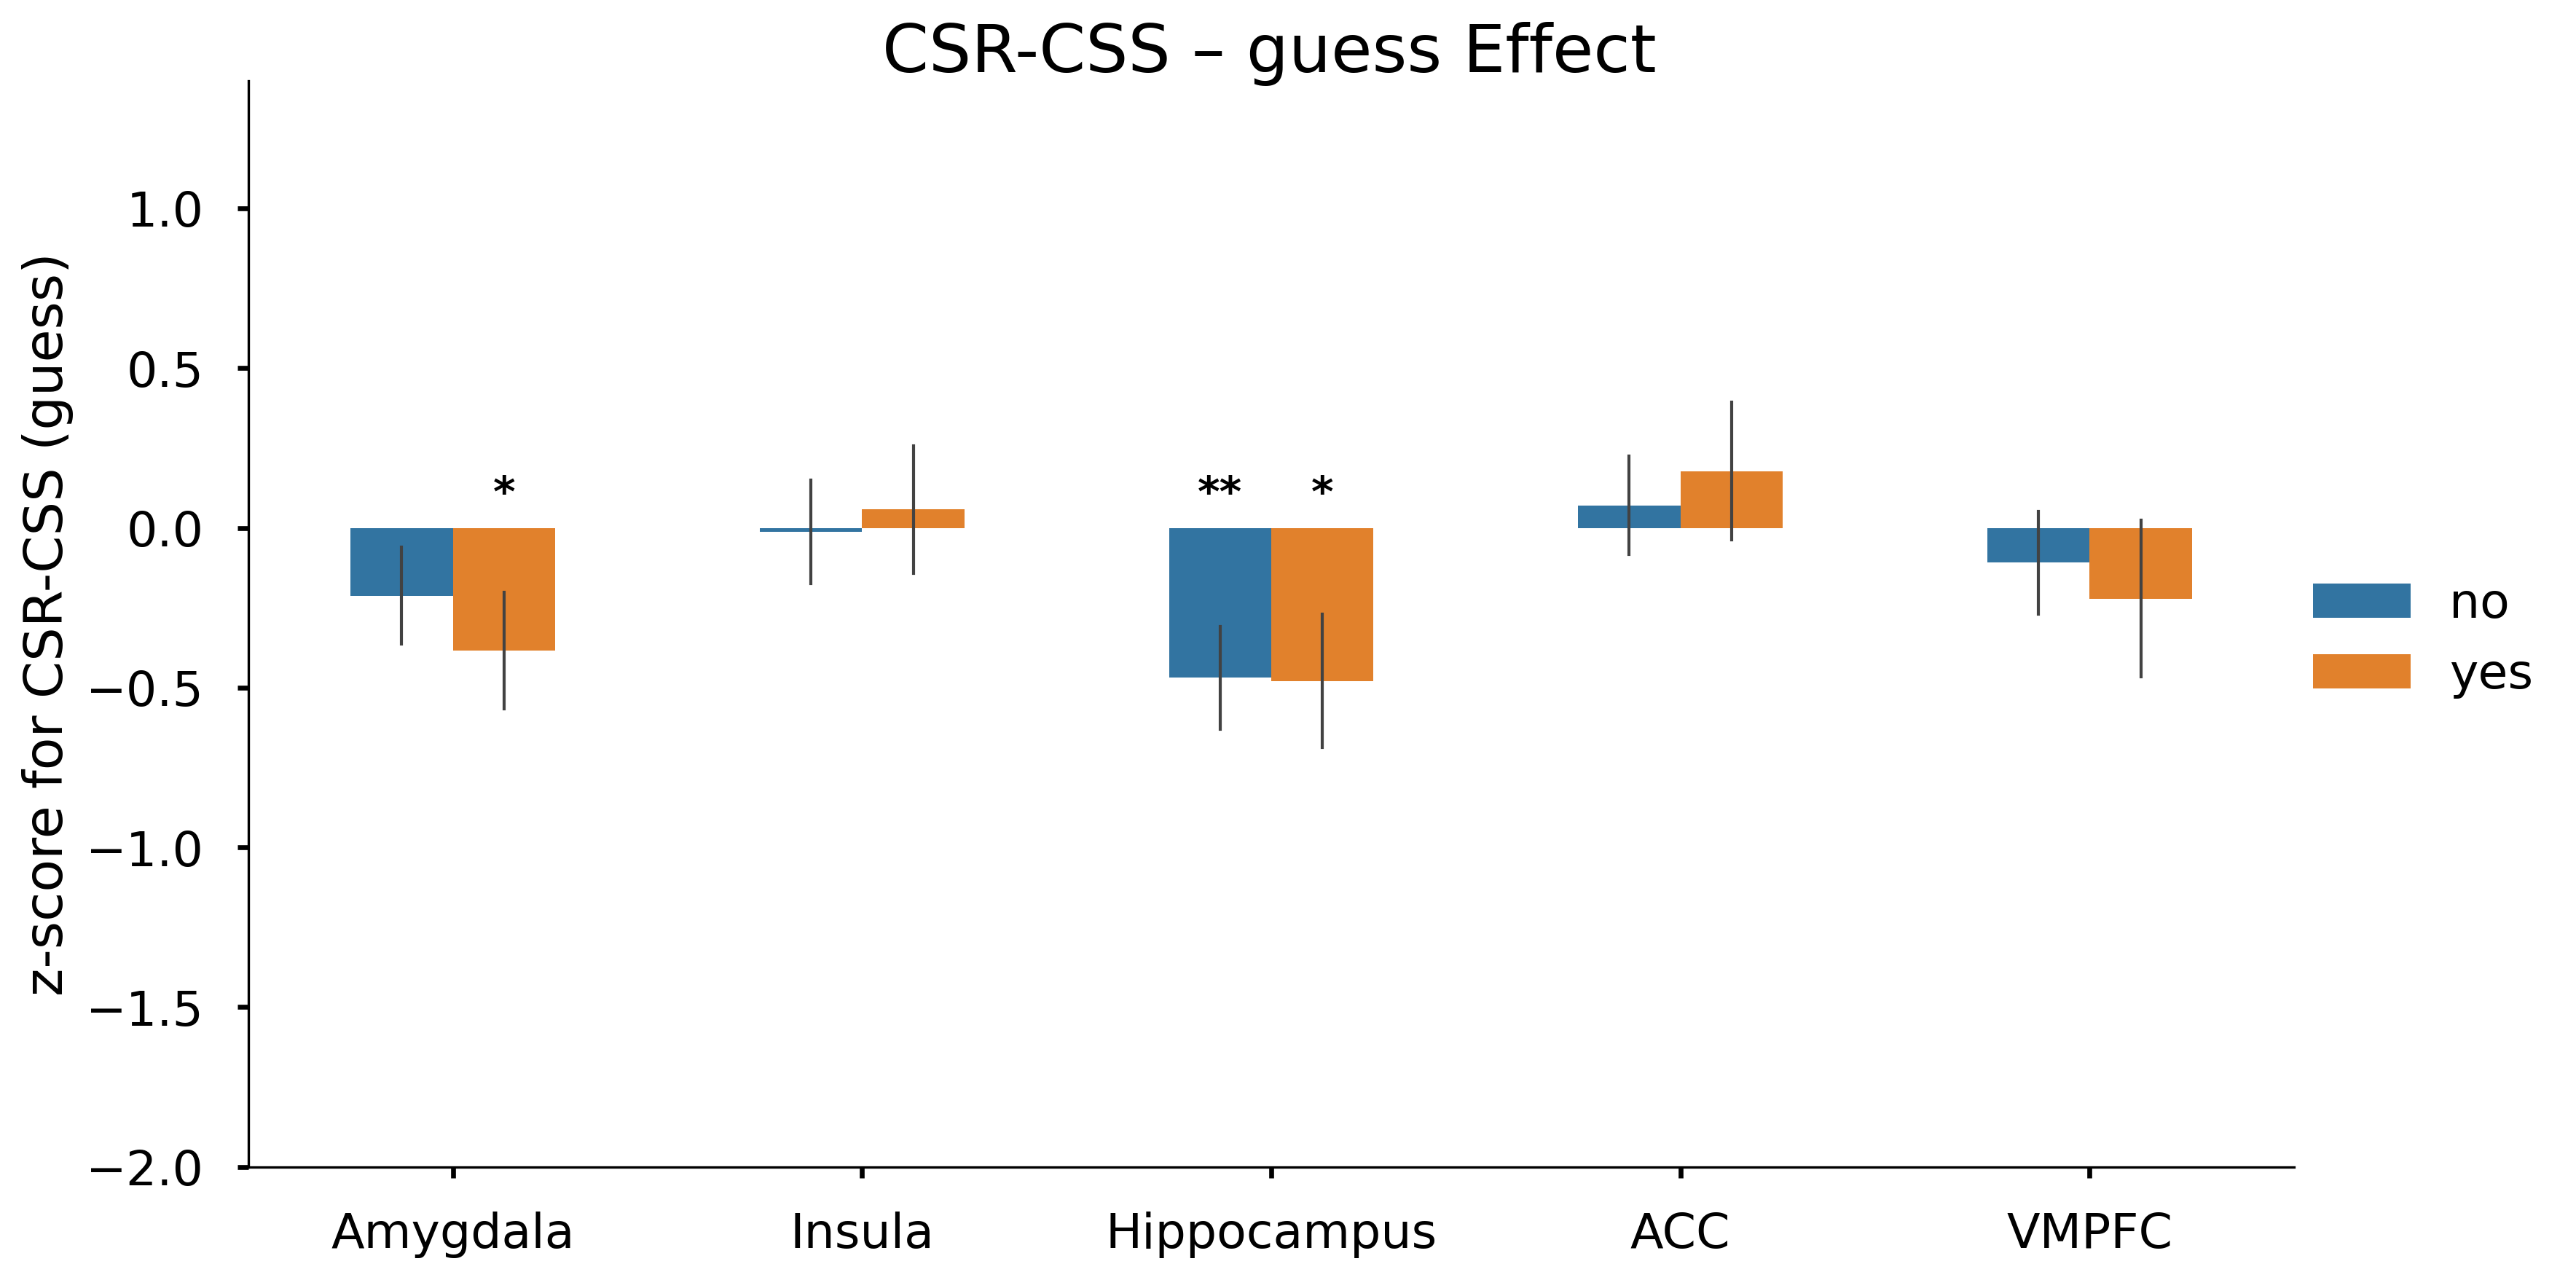


===== Group main effect: CSR-CS- =====

Model results (Z_score ~ guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        guess[T.yes]                                           -0.340    -1.42    98    0.158      
Insula          guess[T.yes]                                            0.025     0.09    98    0.932      
Hippocampus     guess[T.yes]                                           -0.210    -0.69    98    0.490      
ACC             guess[T.yes]                                            0.129     0.44    98    0.661      
VMPFC           guess[T.yes]                                           -0.007    -0.02    98    0.981      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GUESS LEVEL
ROI             Level                      

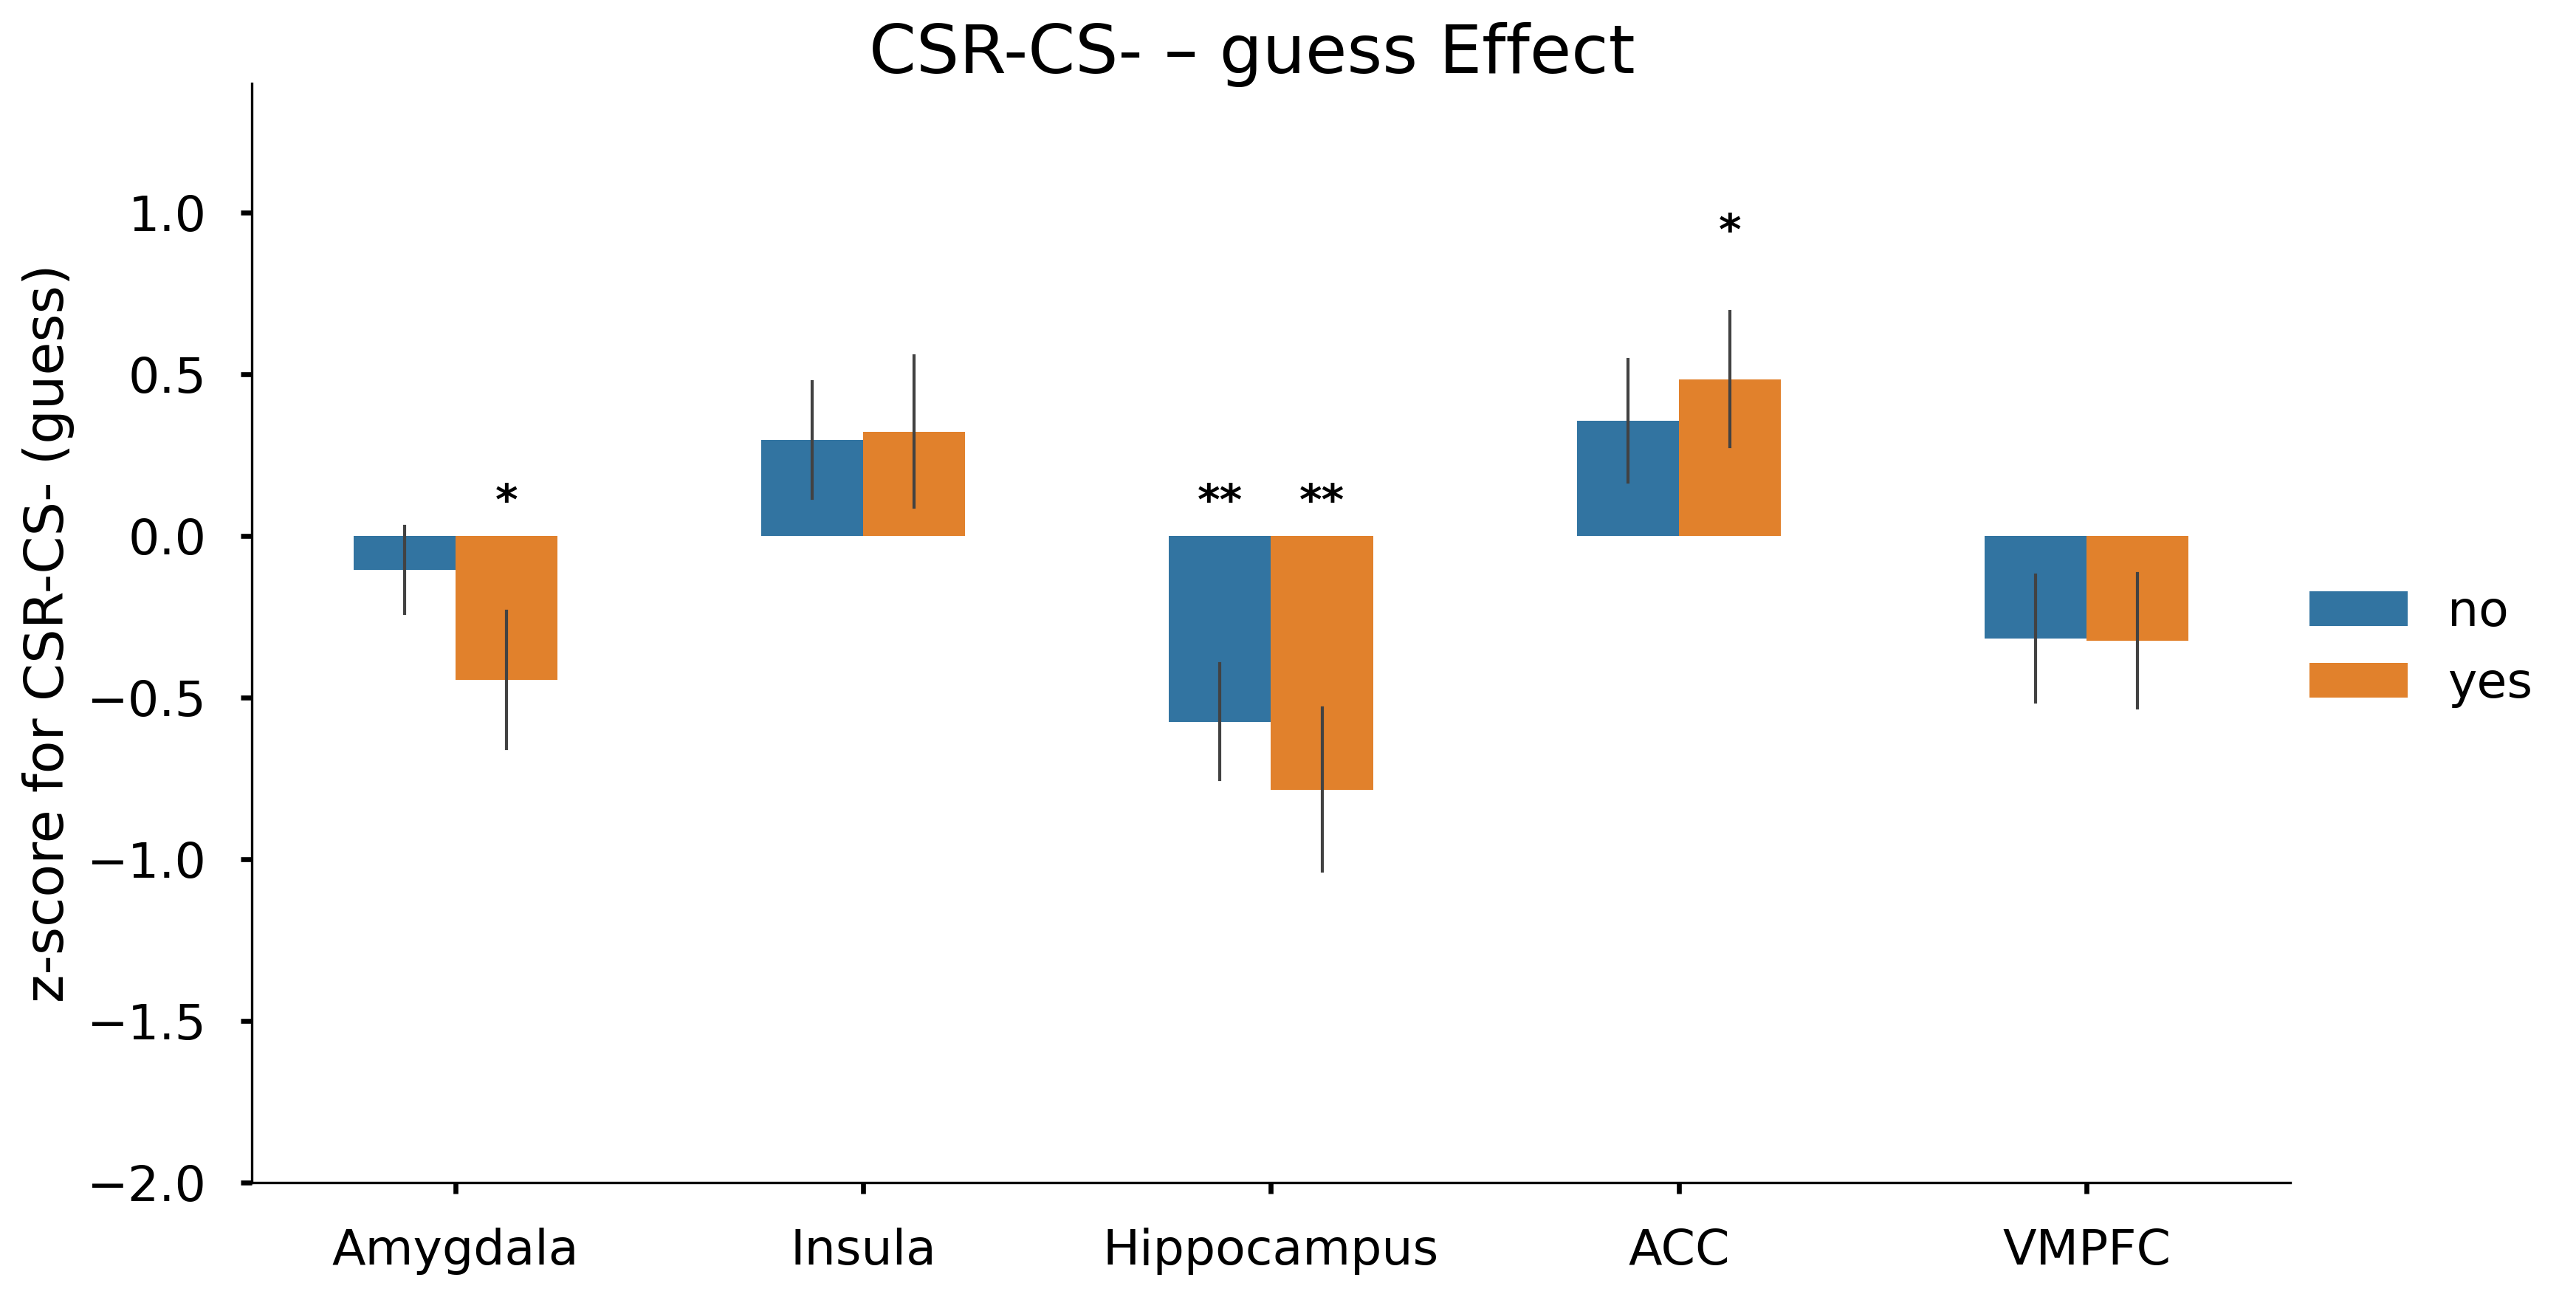


===== Group main effect: CSS-CS- =====

Model results (Z_score ~ guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        guess[T.yes]                                           -0.149    -0.66    98    0.512      
Insula          guess[T.yes]                                           -0.032    -0.11    98    0.913      
Hippocampus     guess[T.yes]                                           -0.192    -0.76    98    0.449      
ACC             guess[T.yes]                                            0.028     0.10    98    0.921      
VMPFC           guess[T.yes]                                            0.116     0.42    98    0.676      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GUESS LEVEL
ROI             Level                      

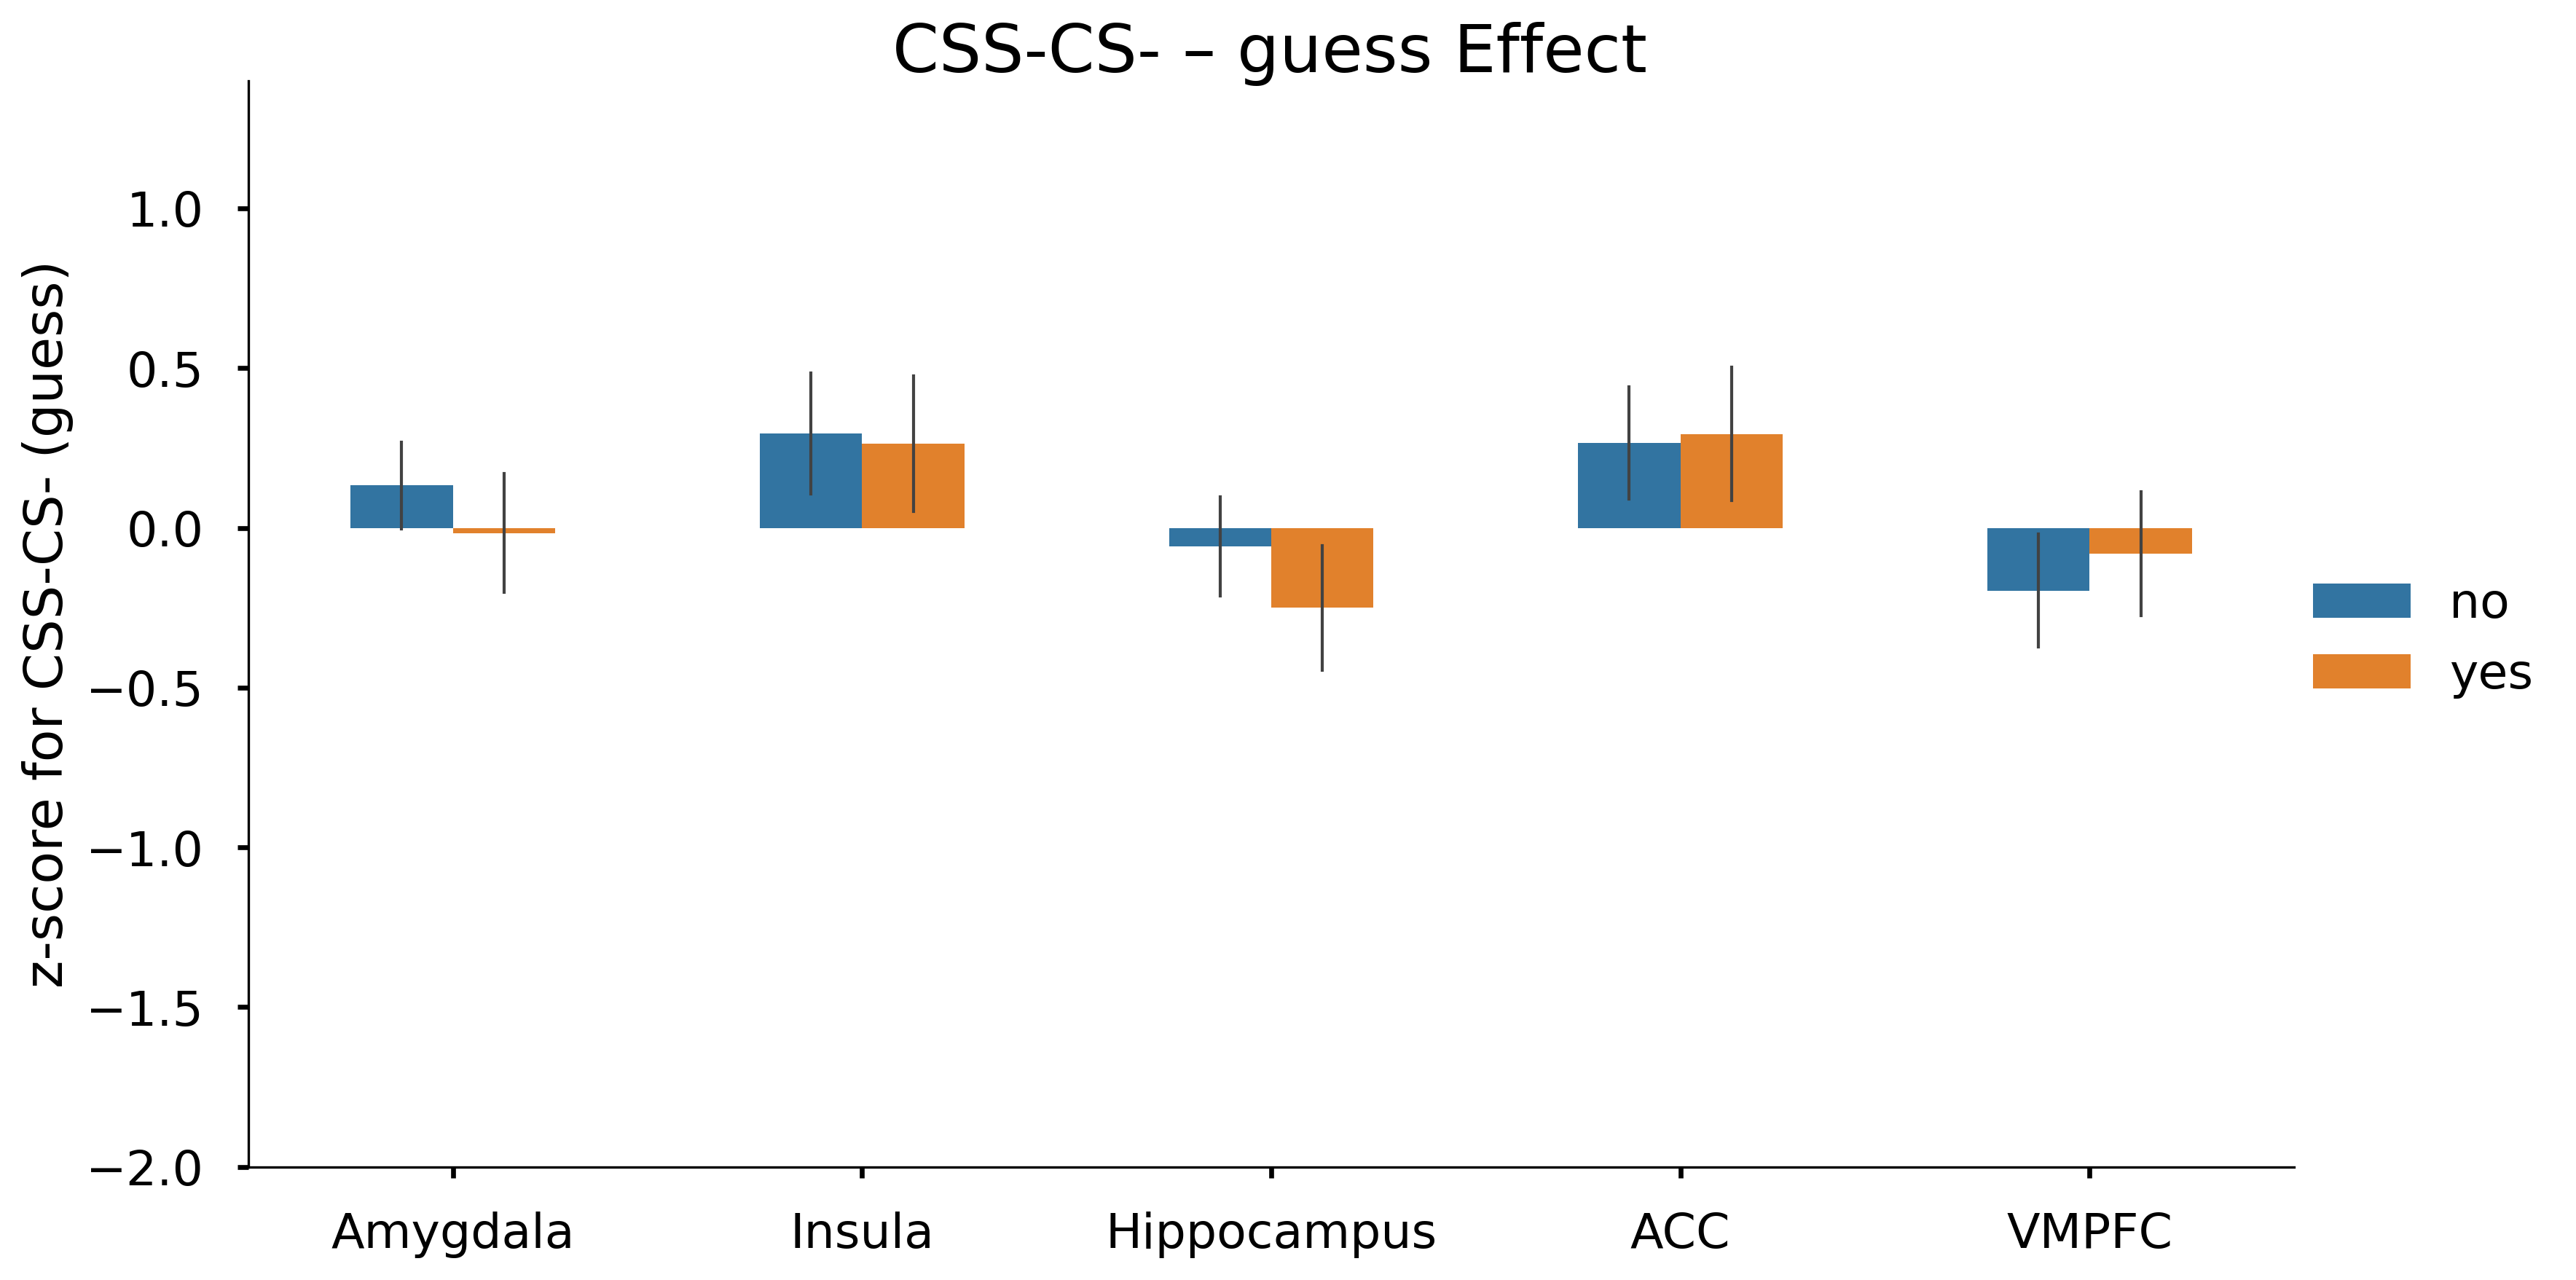


===== Group main effect: CSR-fix =====

Model results (Z_score ~ guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        guess[T.yes]                                           -0.201    -0.76    98    0.451      
Insula          guess[T.yes]                                            0.312     1.26    98    0.212      
Hippocampus     guess[T.yes]                                           -0.059    -0.19    98    0.846      
ACC             guess[T.yes]                                            0.435     1.47    98    0.144      
VMPFC           guess[T.yes]                                            0.094     0.32    98    0.752      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GUESS LEVEL
ROI             Level                      

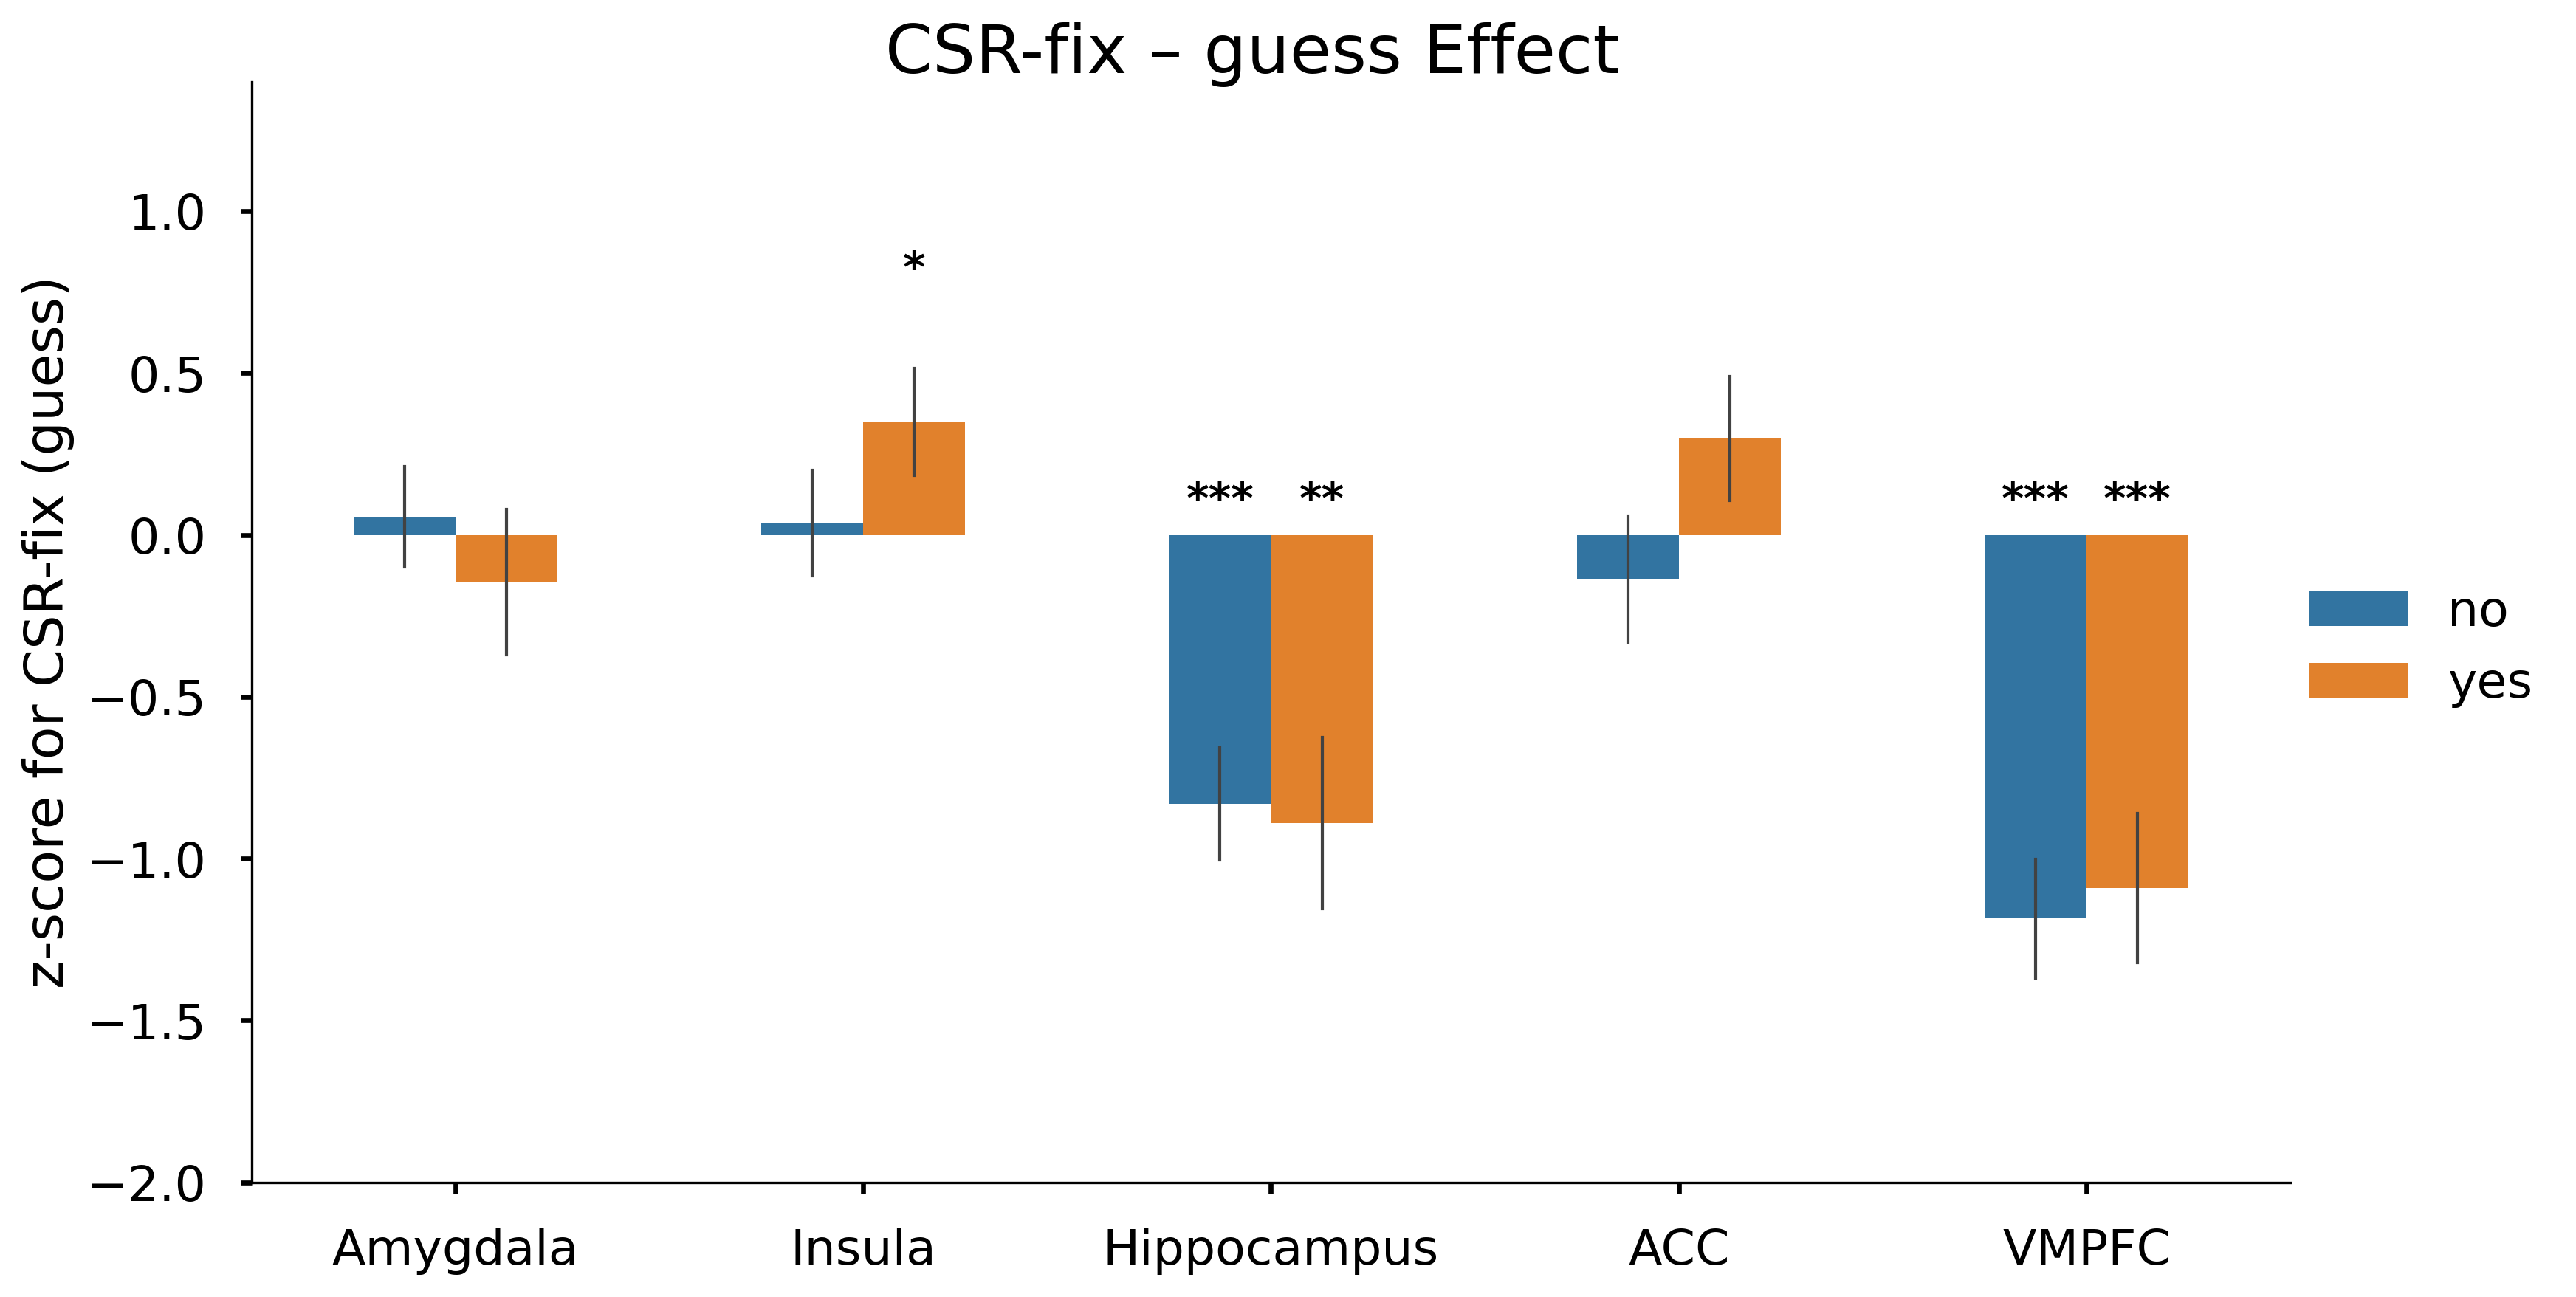


===== Group main effect: CSS-fix =====

Model results (Z_score ~ guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        guess[T.yes]                                            0.030     0.13    98    0.900      
Insula          guess[T.yes]                                            0.205     0.78    98    0.436      
Hippocampus     guess[T.yes]                                           -0.043    -0.18    98    0.860      
ACC             guess[T.yes]                                            0.275     1.03    98    0.304      
VMPFC           guess[T.yes]                                            0.253     0.86    98    0.392      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GUESS LEVEL
ROI             Level                      

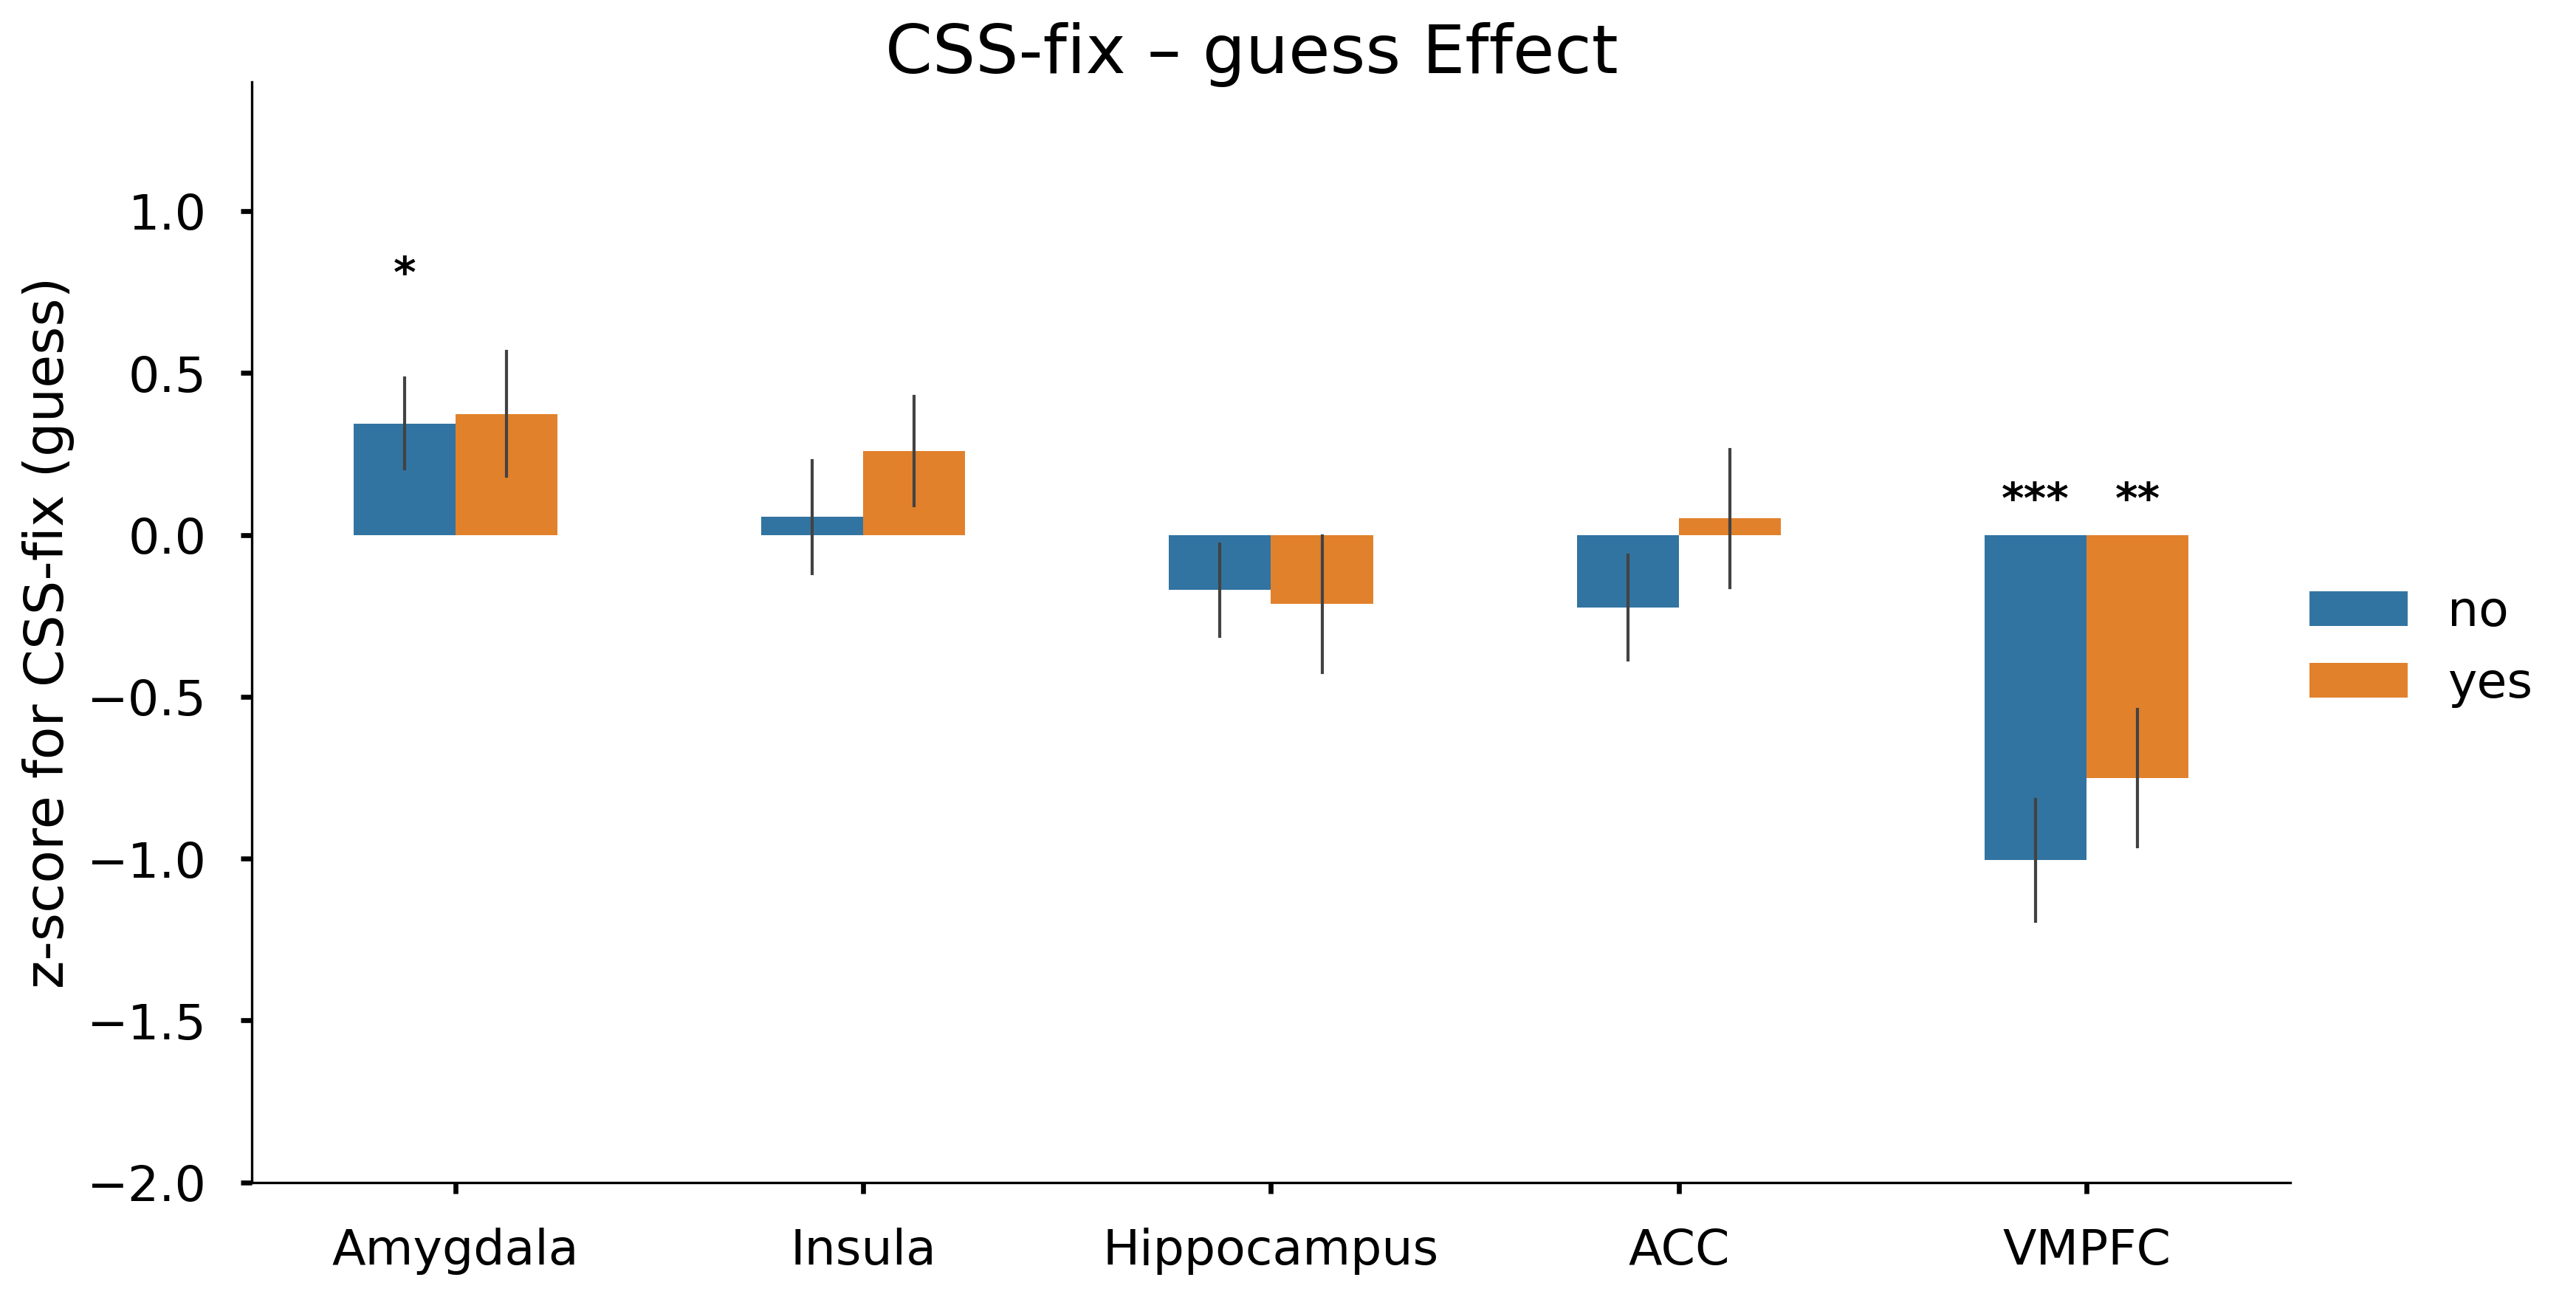


===== Group main effect: CSminus-fix =====

Model results (Z_score ~ guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        guess[T.yes]                                            0.246     1.04    98    0.299      
Insula          guess[T.yes]                                            0.293     0.98    98    0.331      
Hippocampus     guess[T.yes]                                            0.220     0.85    98    0.400      
ACC             guess[T.yes]                                            0.290     0.97    98    0.332      
VMPFC           guess[T.yes]                                            0.119     0.41    98    0.680      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GUESS LEVEL
ROI             Level                  

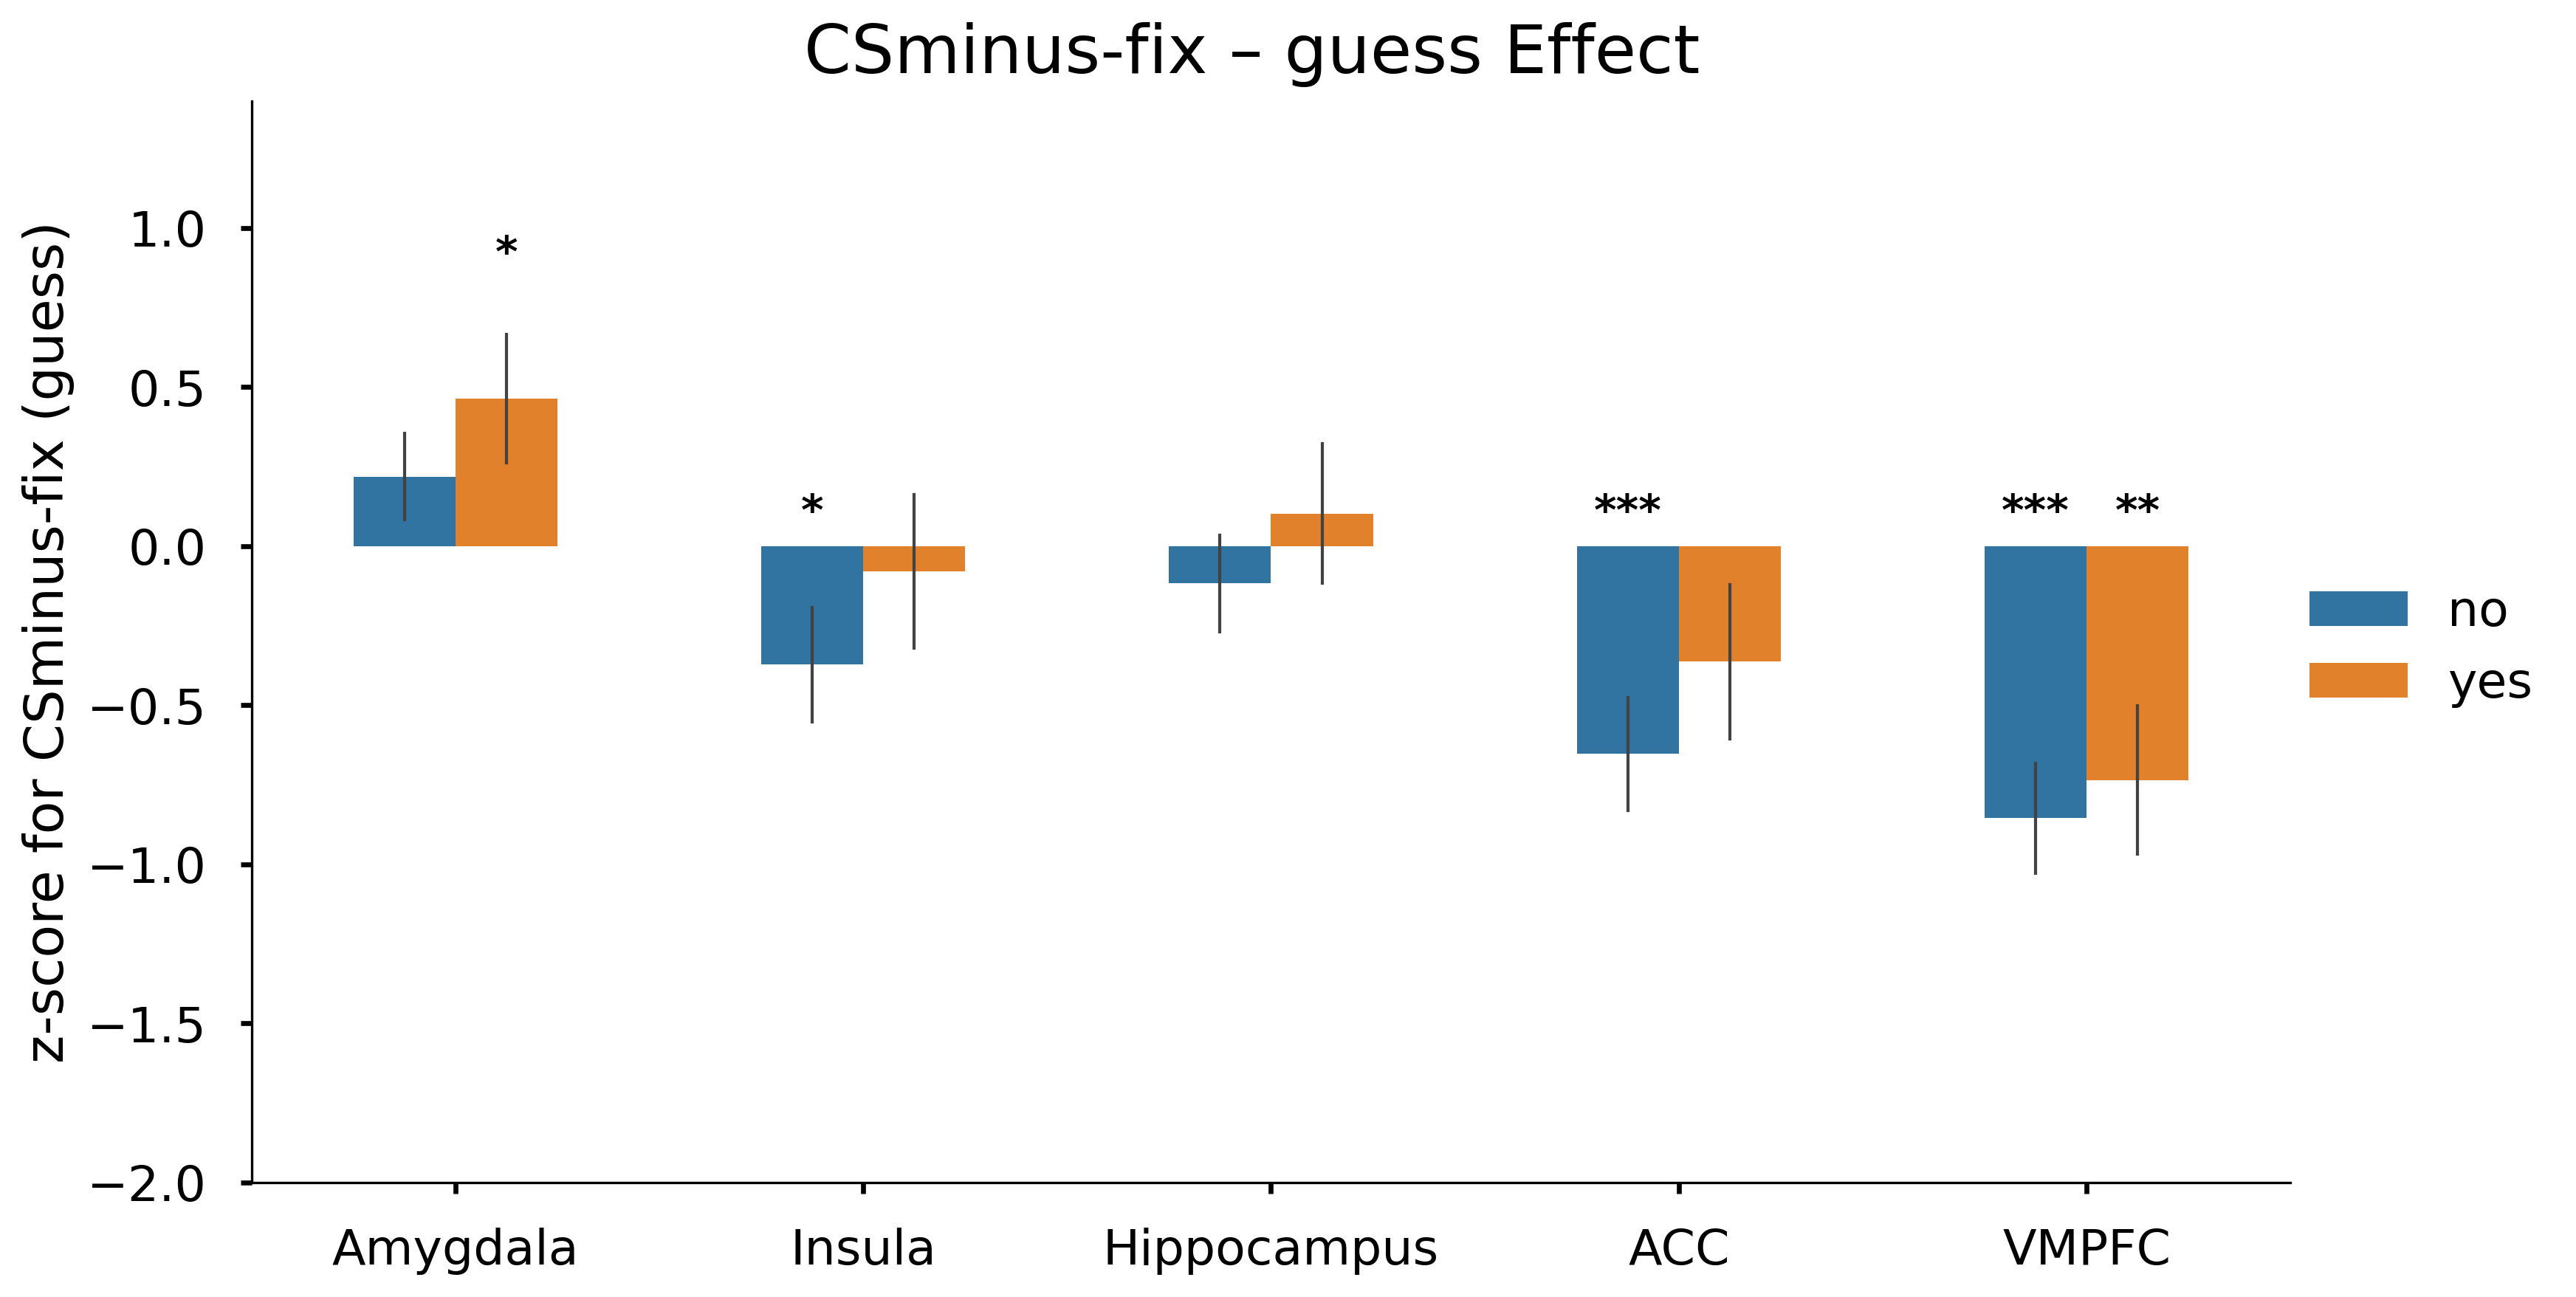

In [ ]:
# 1️⃣ Guess main effect
# ---------------------------------------------------------
for contrast in contrast_list:
    print(f"\n===== Group main effect: {contrast} =====")
    df = df_all.loc[(df_all['Contrast'] == contrast) & (df_all['Drug'] == 'Placebo') & (df_all['Phase'] == 'phase2')]

    g = sns.catplot(
        x='ROI', y='Z_score', hue='guess',
        order=ROI_list, hue_order=guess_list,
        kind='bar', errorbar='se', 
        height=6, aspect=1.8, width=0.5, 
        err_kws={'linewidth': 1},
        data=df
    )

    ax = g.ax
    add_sig_stars(ax, df, ROI_list, get_matching_model_terms(model, "guess")[0], hue_order=guess_list)


    g.set_axis_labels('', f'z-score for {contrast} (guess)')
    g.set(ylim=(-2, 1.4))
    g.legend.set_title('')
    g.figure.suptitle(f'{contrast} – guess Effect', fontsize=22, y=1.02)
    g.figure.set_dpi(300)
    plt.savefig(f'{plot_dir}/{contrast}_guess_sig.png', bbox_inches='tight')
    plt.show()


===== Group main effect: CSR-CSS =====

Model results (Z_score ~ Group + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                             0.327     0.94    46    0.350      
Insula          Group[T.HC]                                             0.180     0.47    46    0.644      
Hippocampus     Group[T.HC]                                             0.357     0.88    46    0.382      
ACC             Group[T.HC]                                             0.230     0.66    46    0.514      
VMPFC           Group[T.HC]                                            -0.125    -0.34    46    0.732      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GROUP LEVEL
ROI             Level              

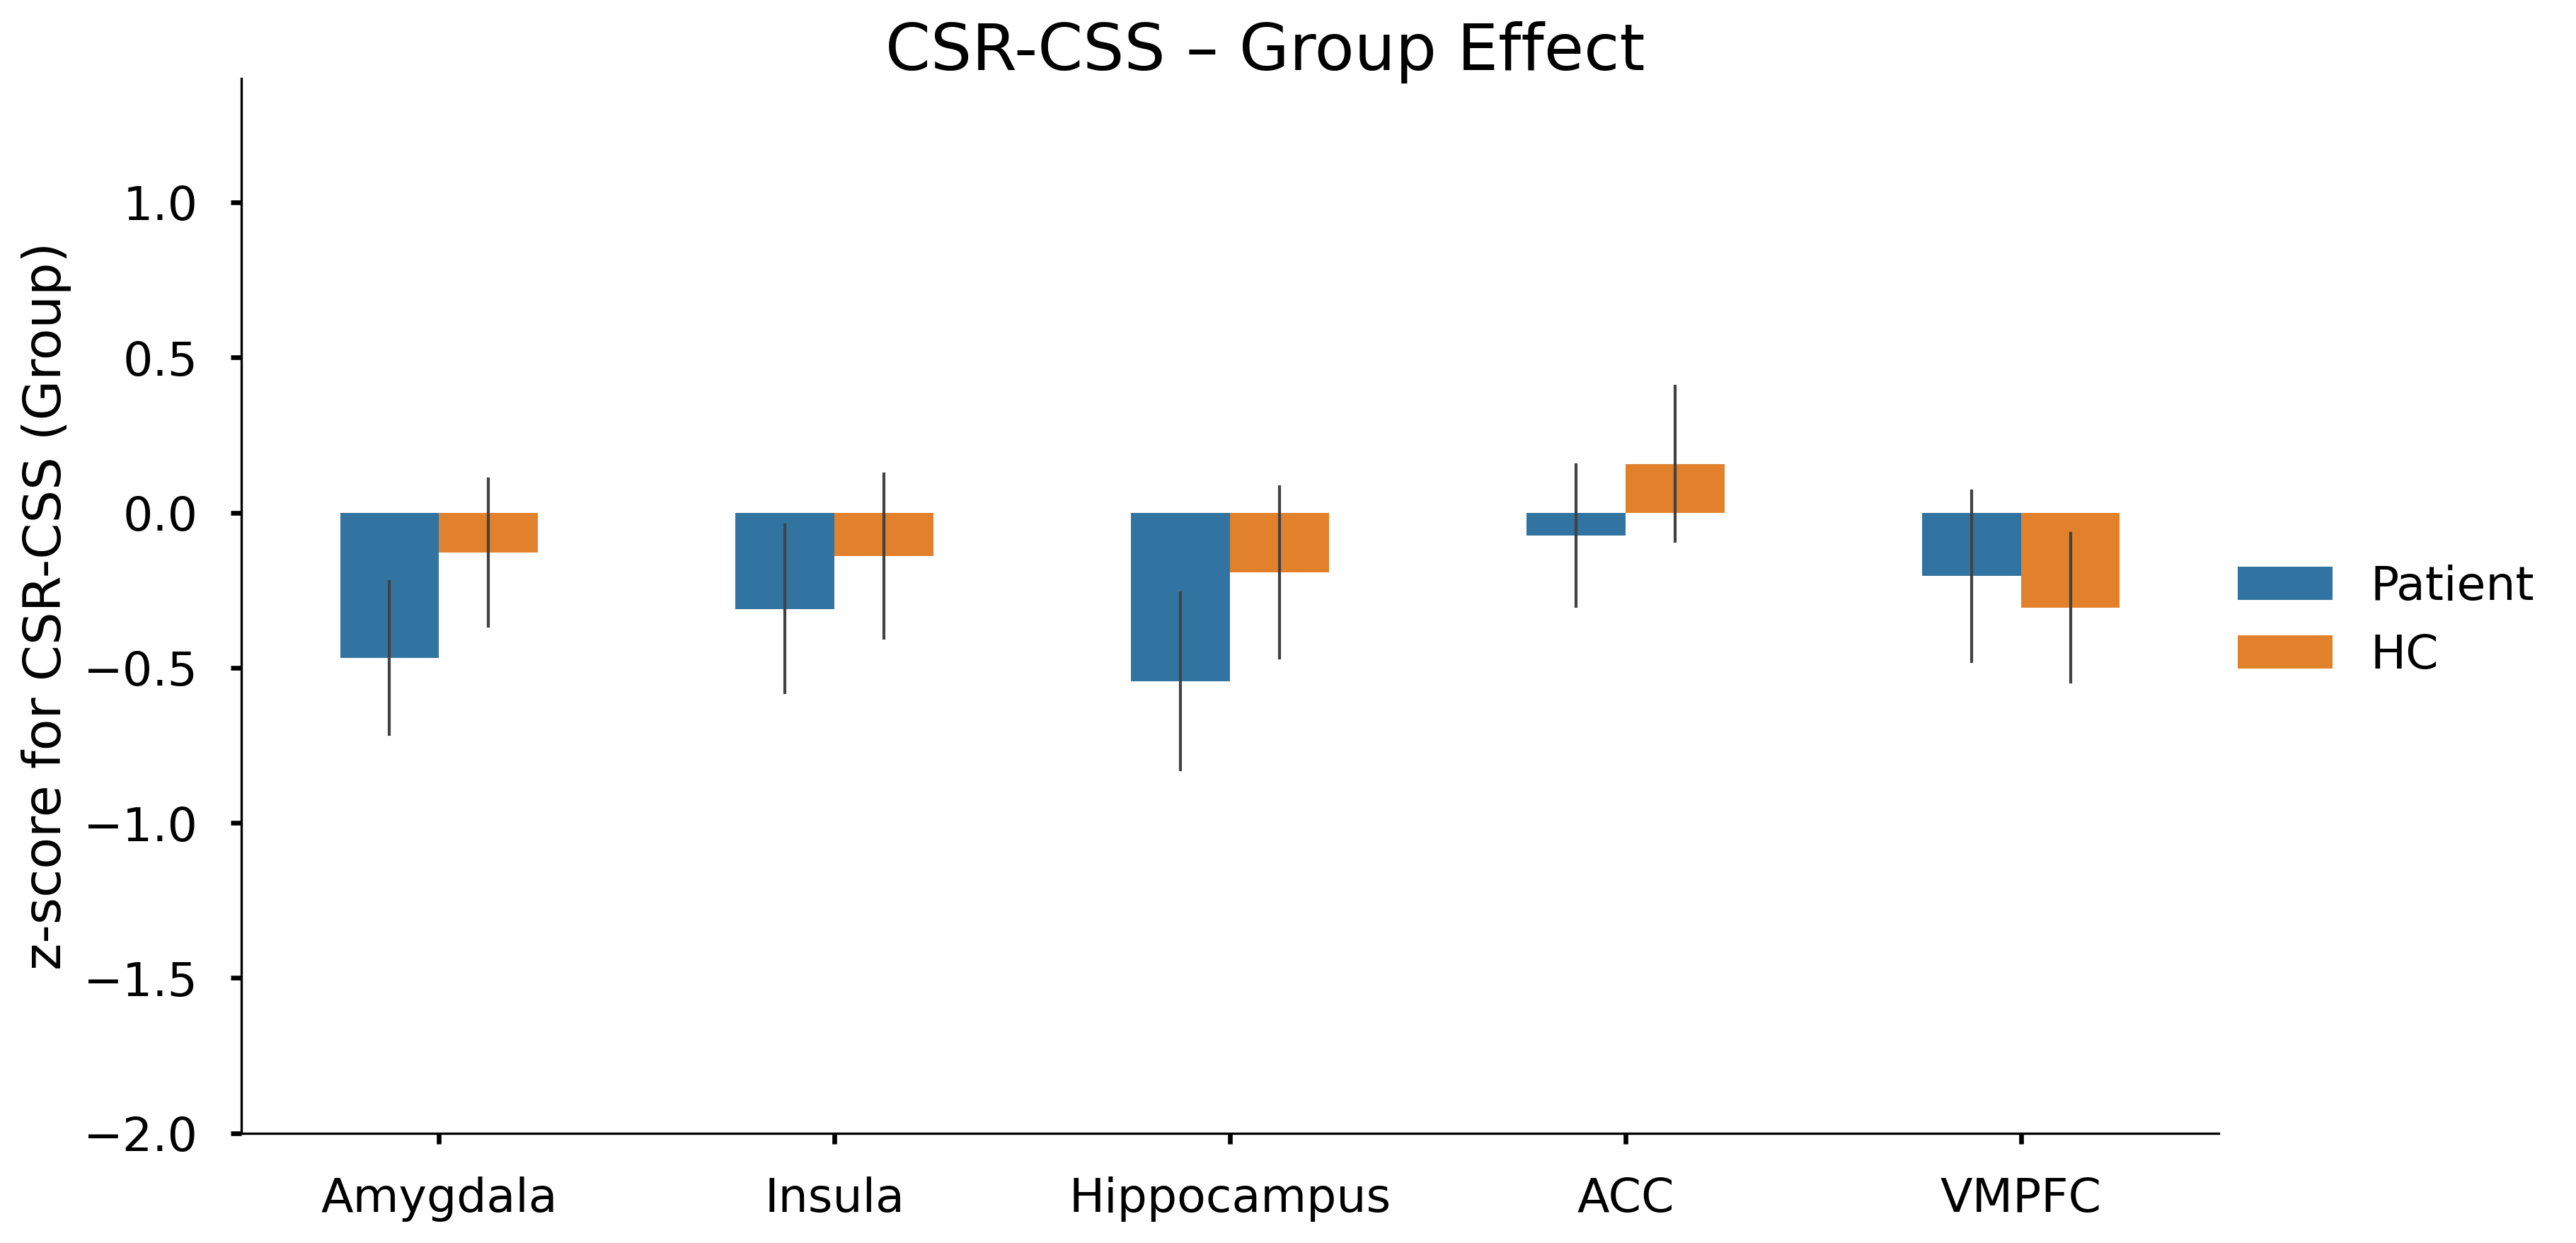


===== Group main effect: CSR-CS- =====

Model results (Z_score ~ Group + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                             0.035     0.10    46    0.918      
Insula          Group[T.HC]                                             0.322     0.86    46    0.394      
Hippocampus     Group[T.HC]                                             0.216     0.49    46    0.628      
ACC             Group[T.HC]                                             0.567     1.56    46    0.126      
VMPFC           Group[T.HC]                                             0.009     0.02    46    0.980      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GROUP LEVEL
ROI             Level              

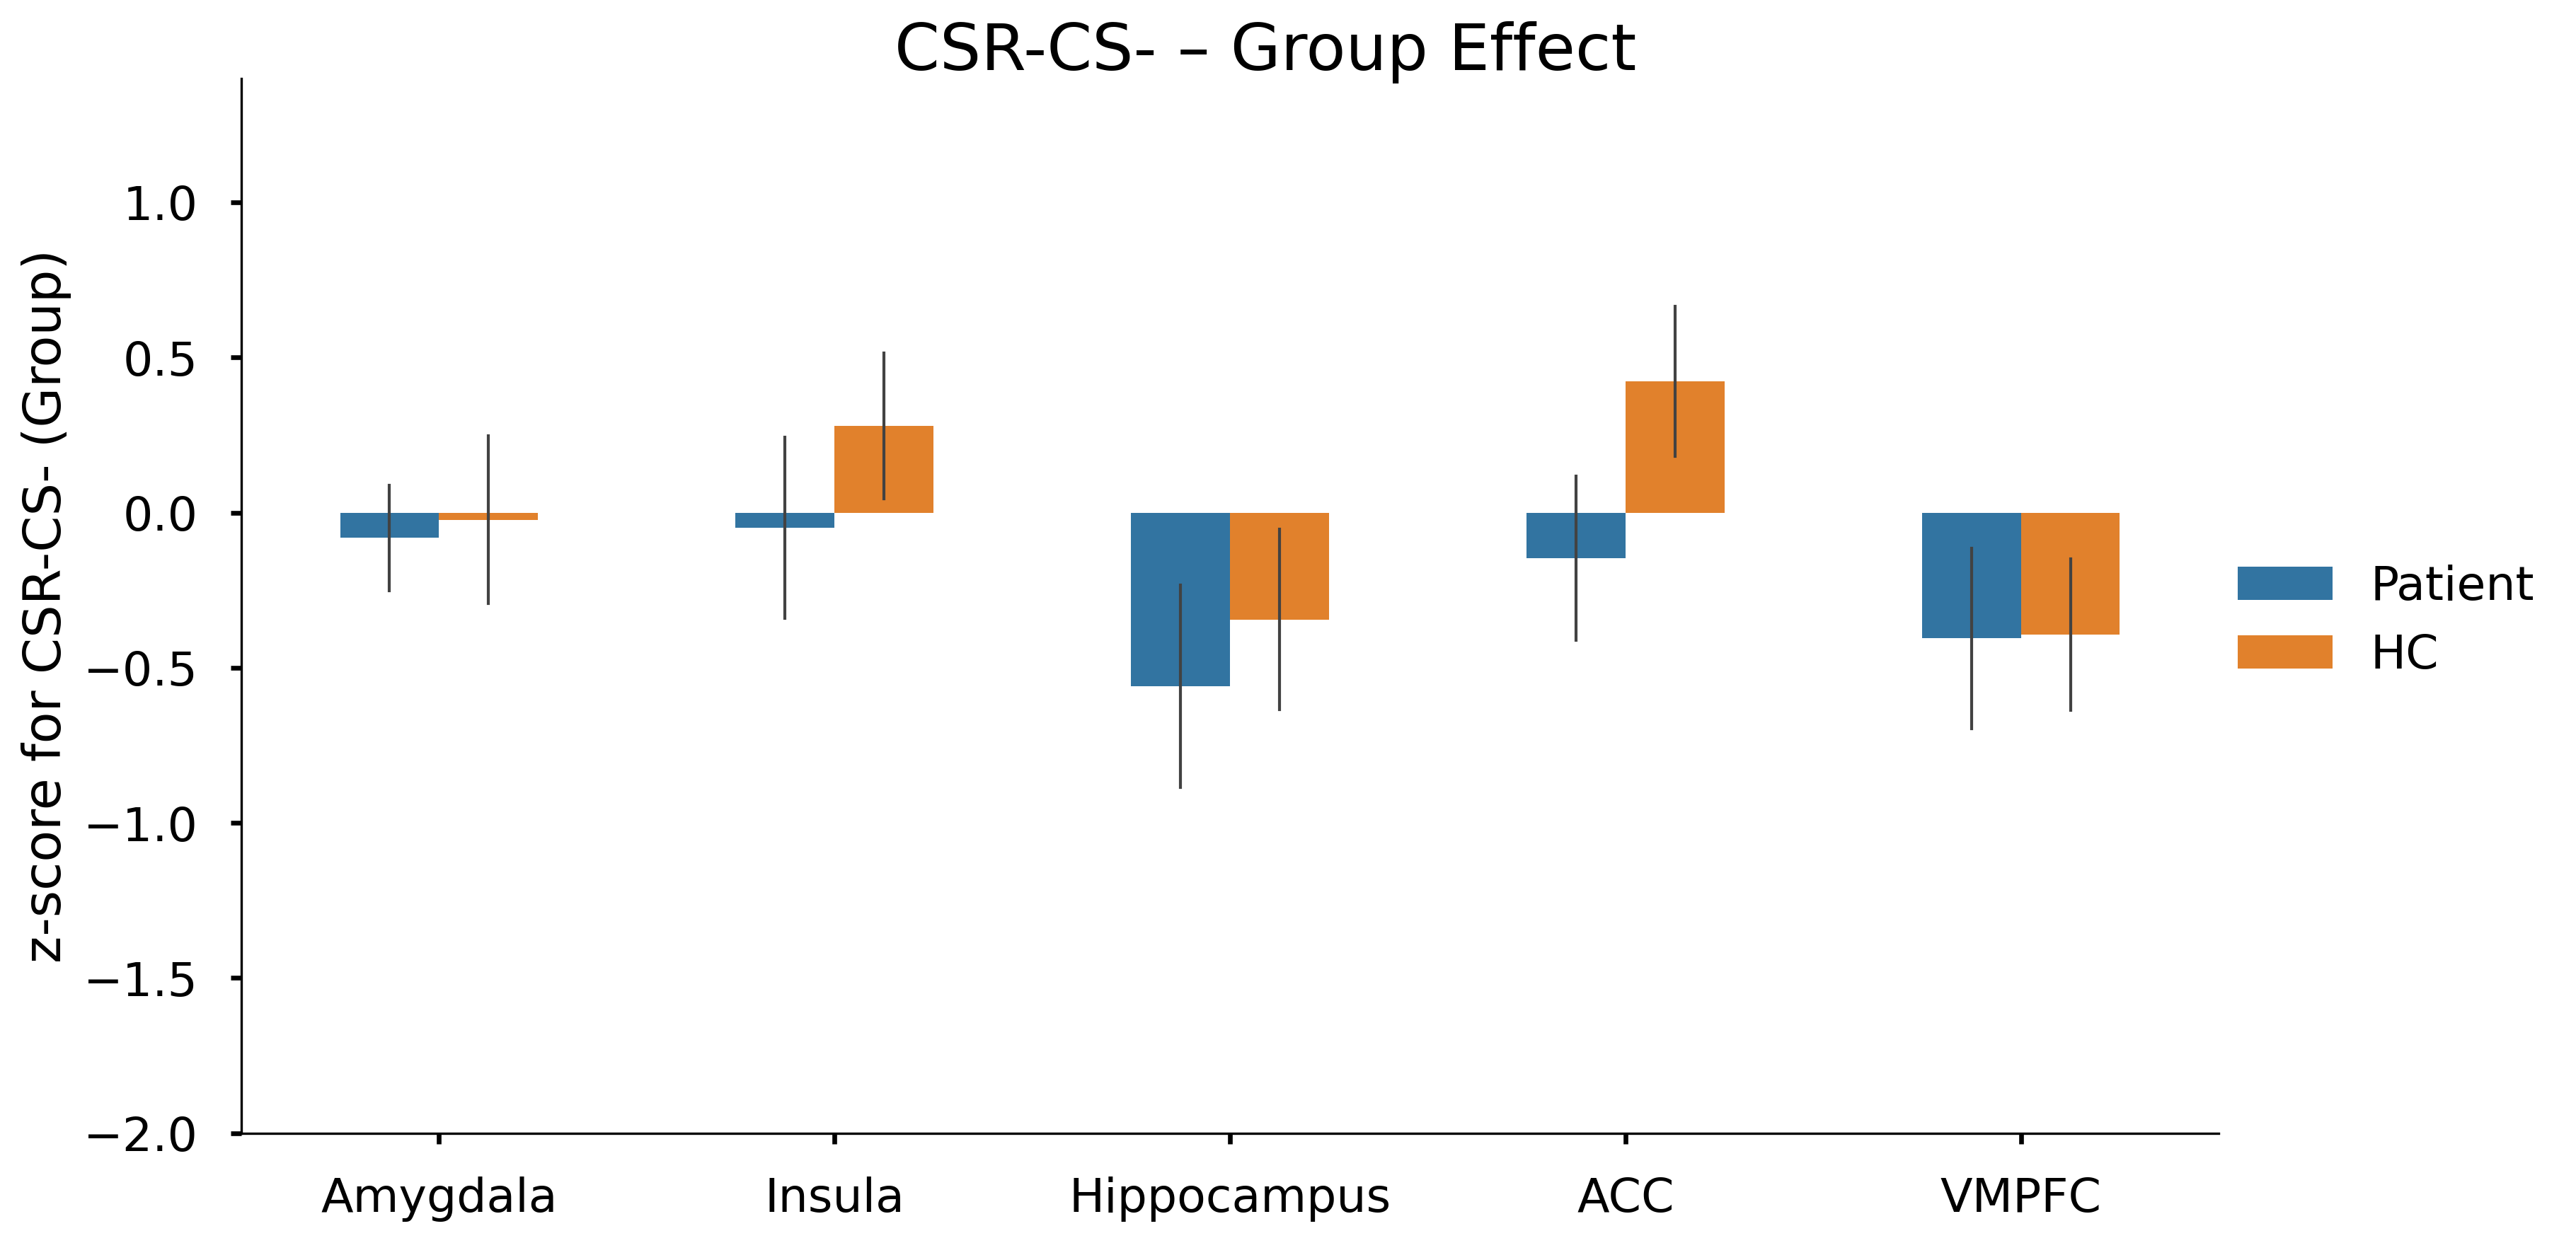


===== Group main effect: CSS-CS- =====

Model results (Z_score ~ Group + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                            -0.312    -0.88    46    0.384      
Insula          Group[T.HC]                                             0.115     0.28    46    0.784      
Hippocampus     Group[T.HC]                                            -0.178    -0.44    46    0.660      
ACC             Group[T.HC]                                             0.315     0.84    46    0.405      
VMPFC           Group[T.HC]                                             0.144     0.34    46    0.737      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GROUP LEVEL
ROI             Level              

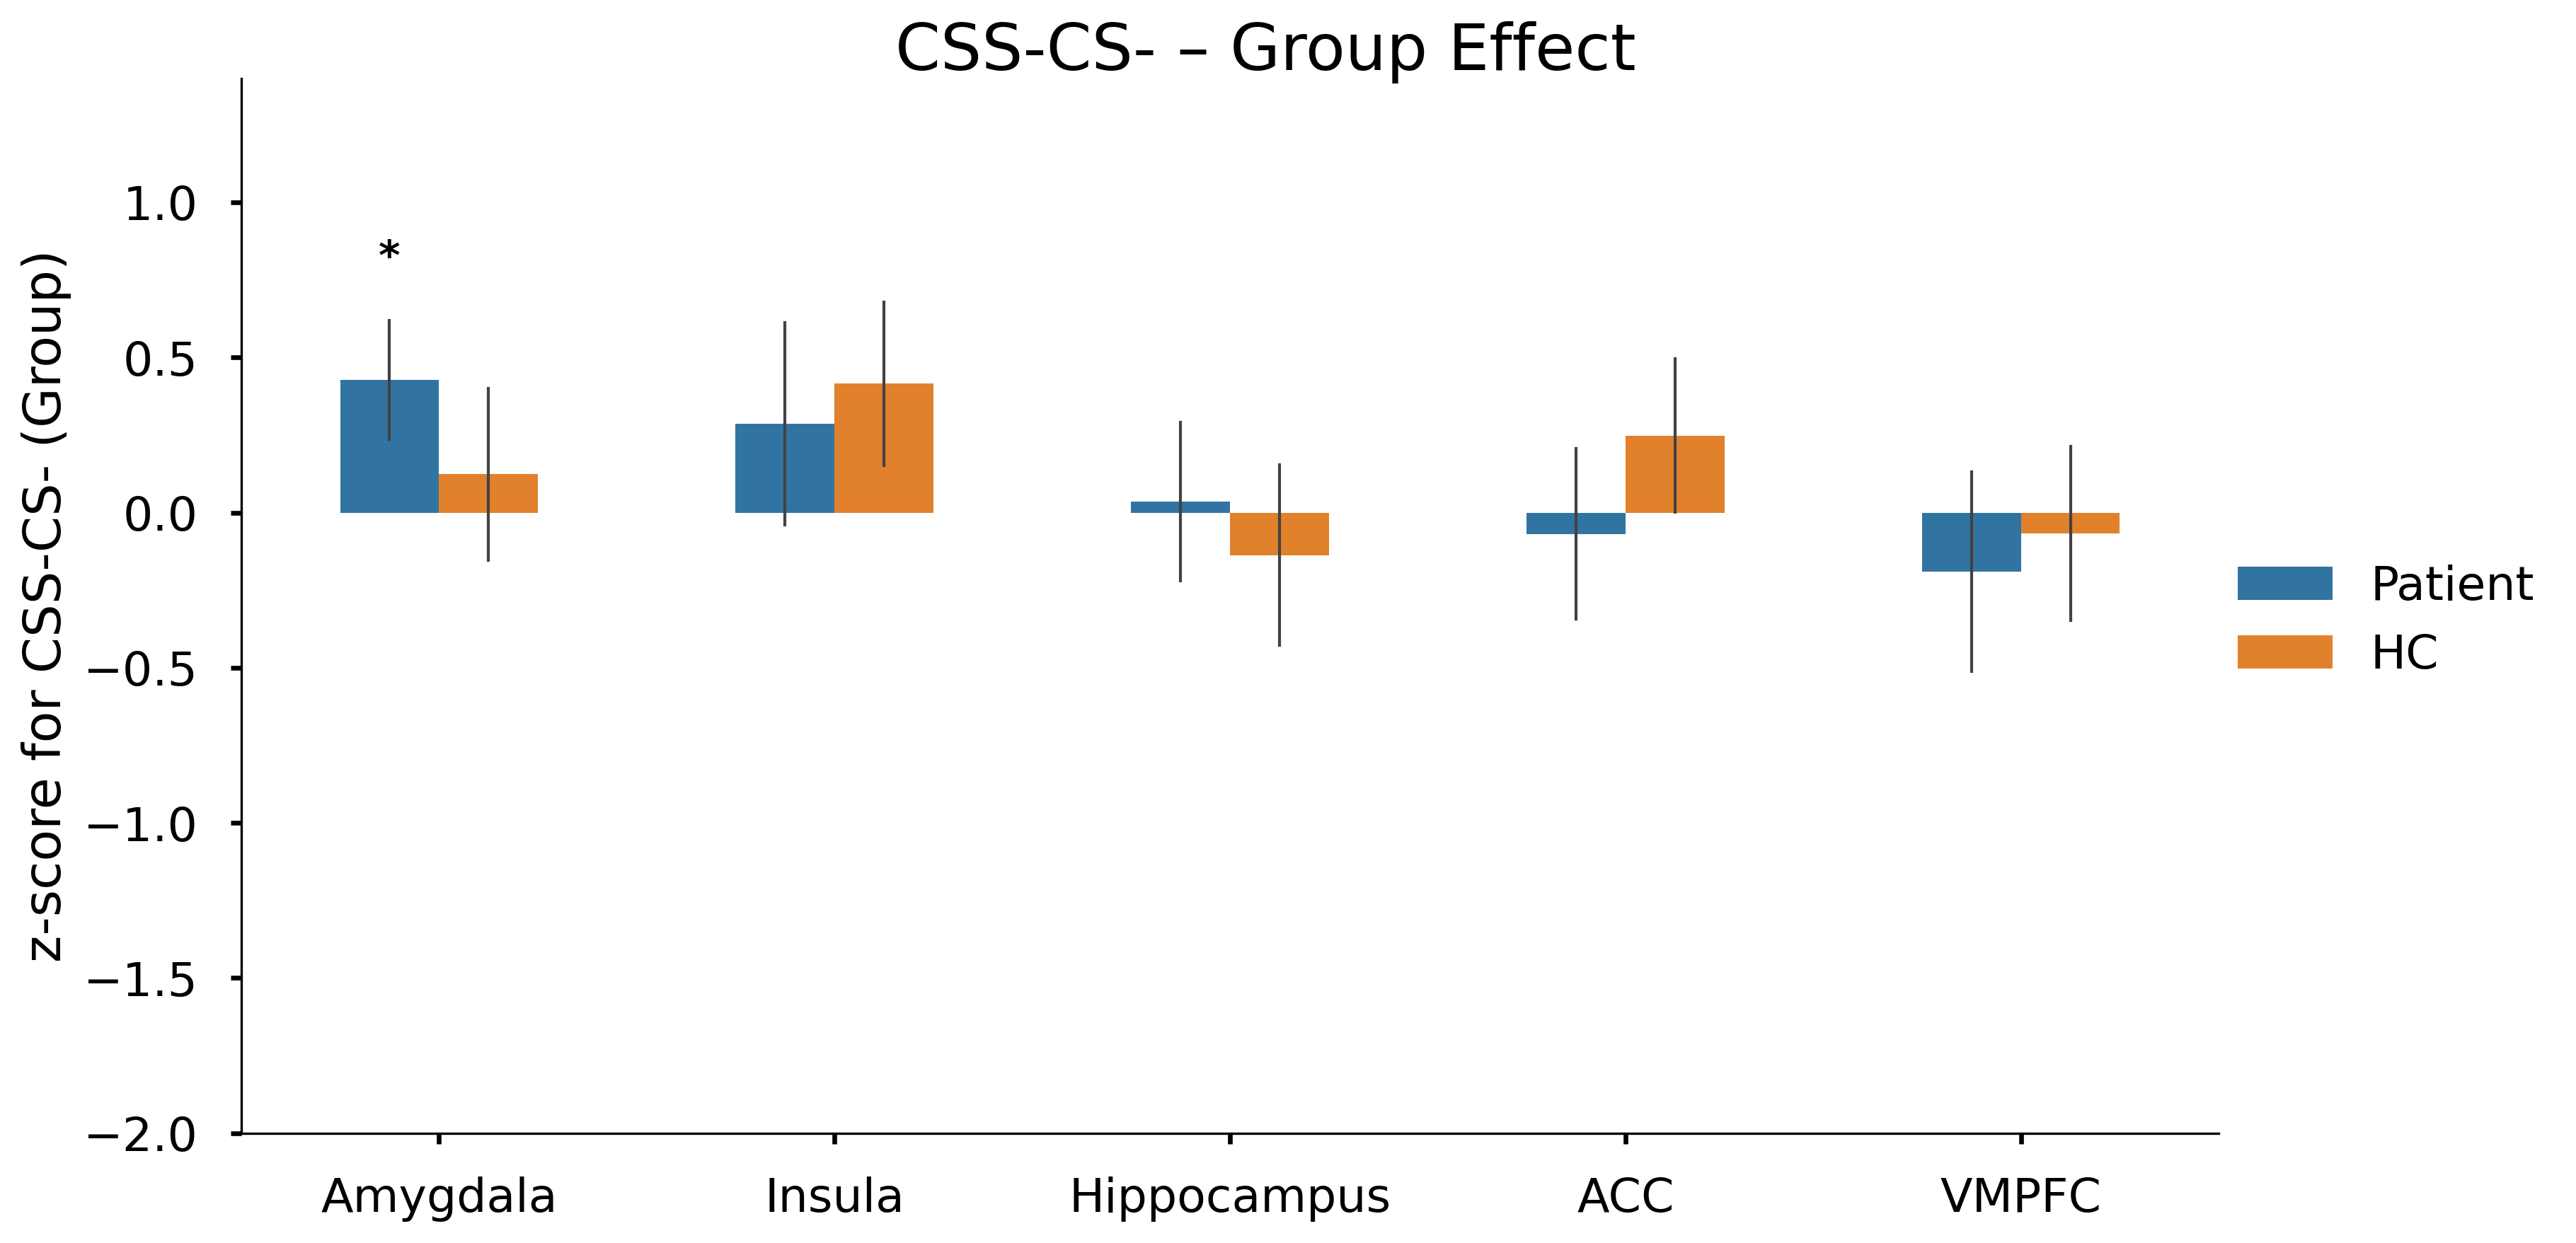


===== Group main effect: CSR-fix =====

Model results (Z_score ~ Group + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                             0.082     0.23    46    0.823      
Insula          Group[T.HC]                                             0.345     0.96    46    0.341      
Hippocampus     Group[T.HC]                                             0.139     0.30    46    0.764      
ACC             Group[T.HC]                                             0.676     1.57    46    0.124      
VMPFC           Group[T.HC]                                             0.317     0.82    46    0.417      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GROUP LEVEL
ROI             Level              

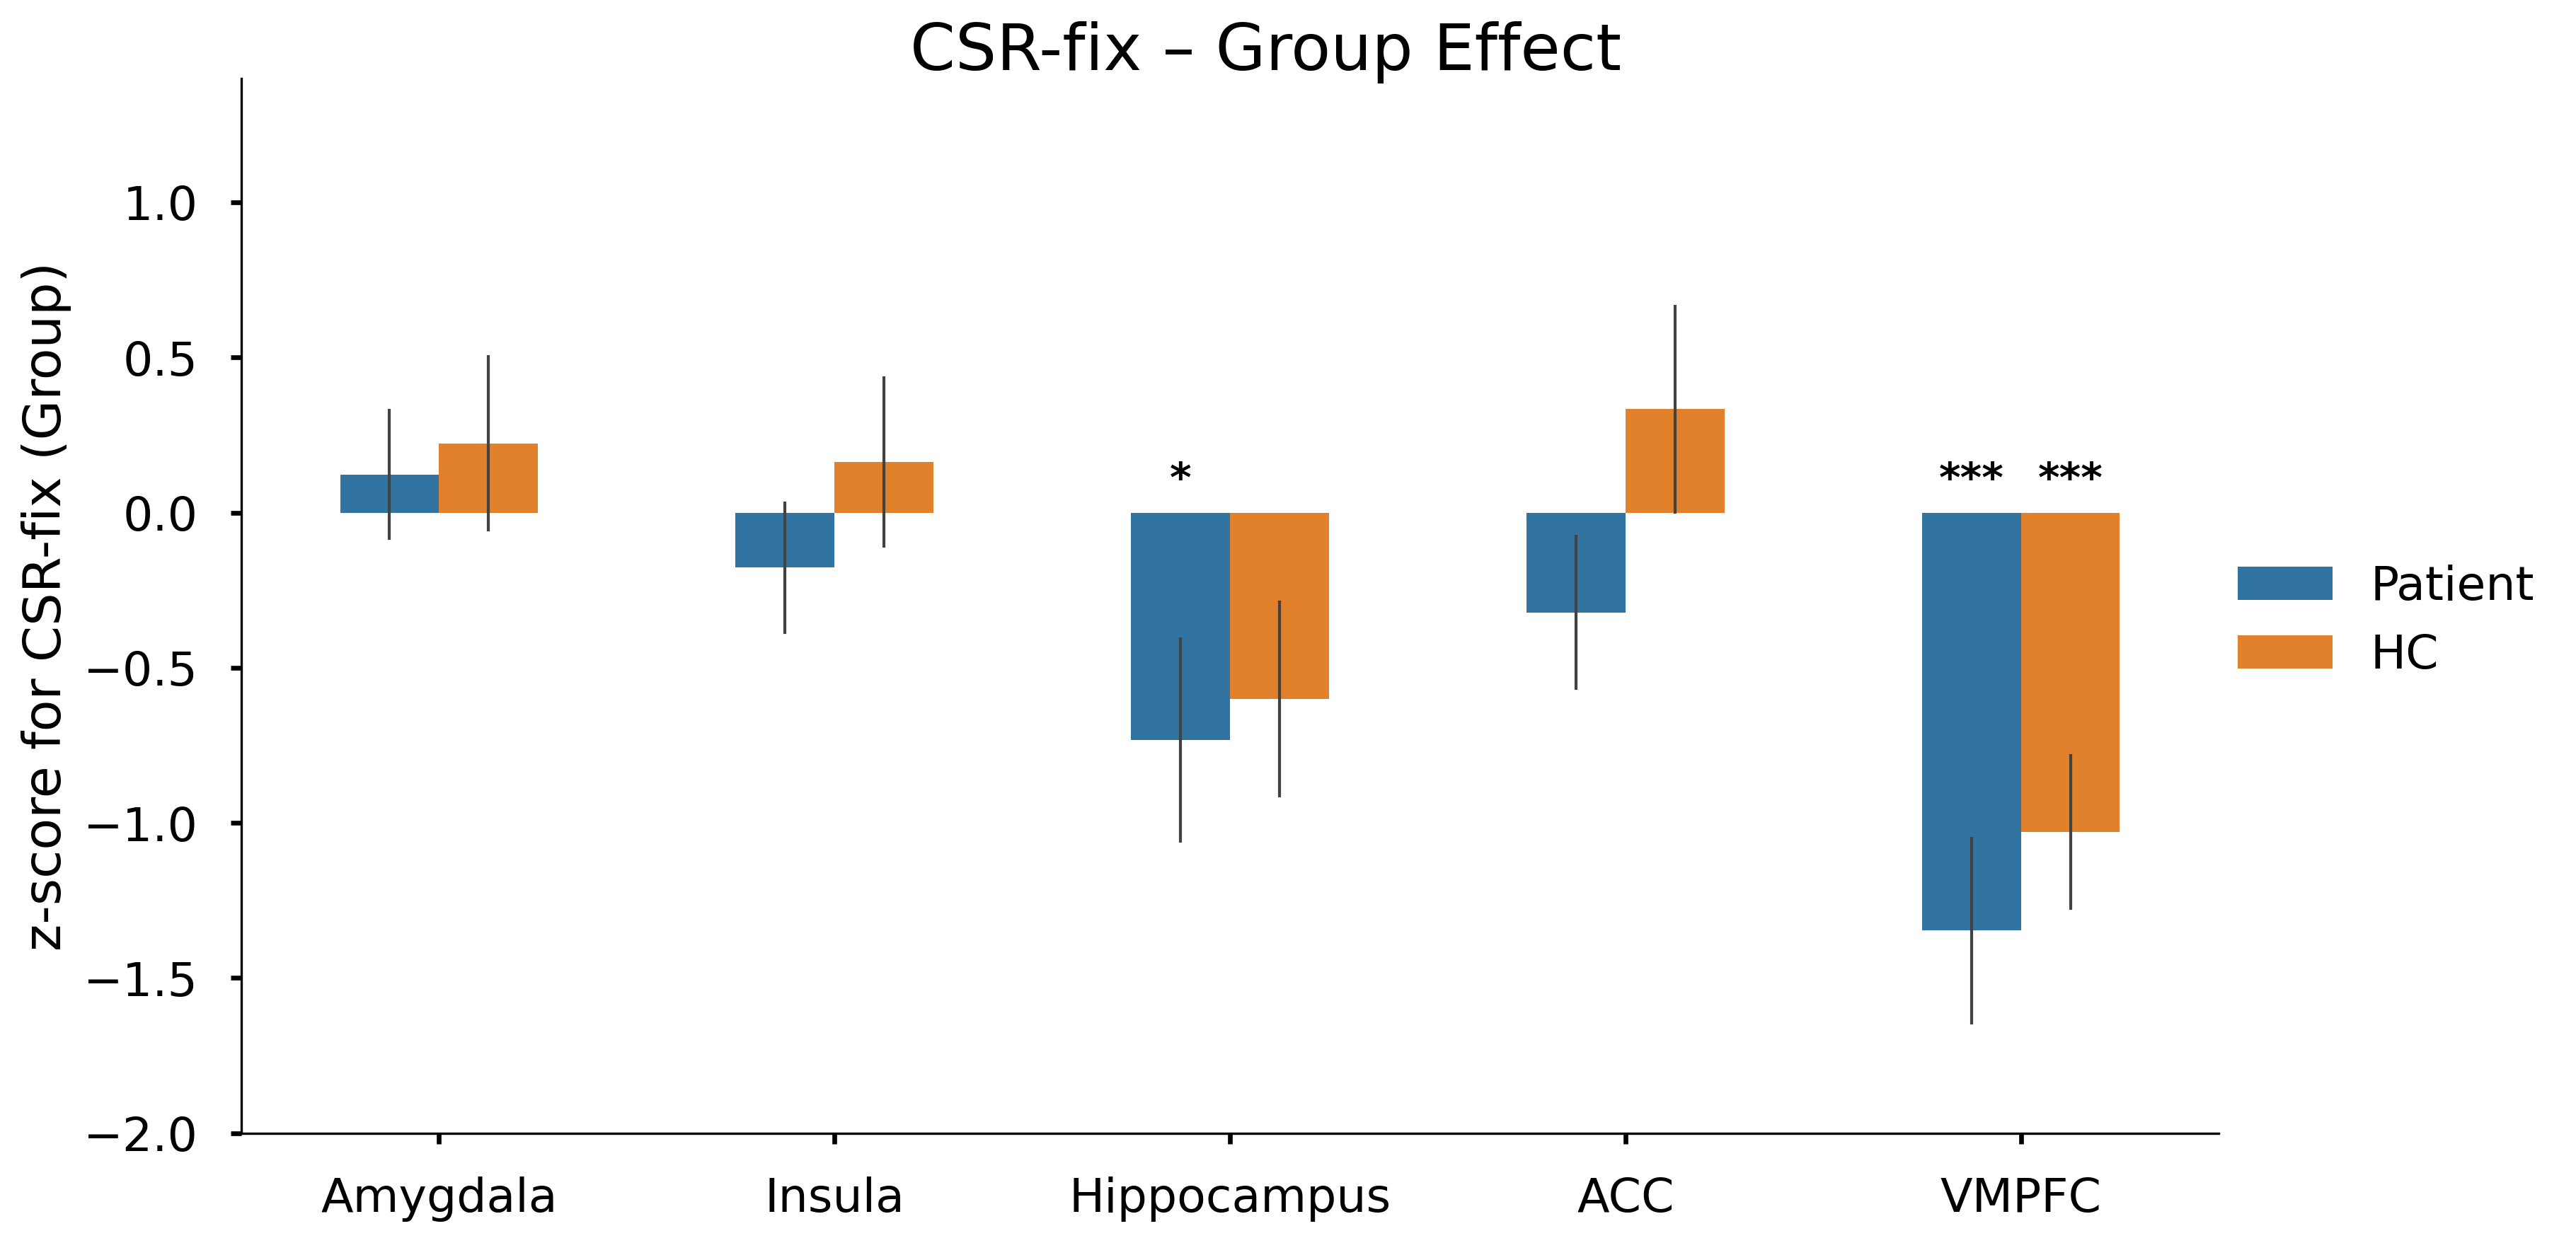


===== Group main effect: CSS-fix =====

Model results (Z_score ~ Group + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                            -0.353    -1.21    46    0.232      
Insula          Group[T.HC]                                             0.100     0.27    46    0.787      
Hippocampus     Group[T.HC]                                            -0.330    -0.98    46    0.333      
ACC             Group[T.HC]                                             0.349     0.97    46    0.336      
VMPFC           Group[T.HC]                                             0.468     1.11    46    0.274      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GROUP LEVEL
ROI             Level              

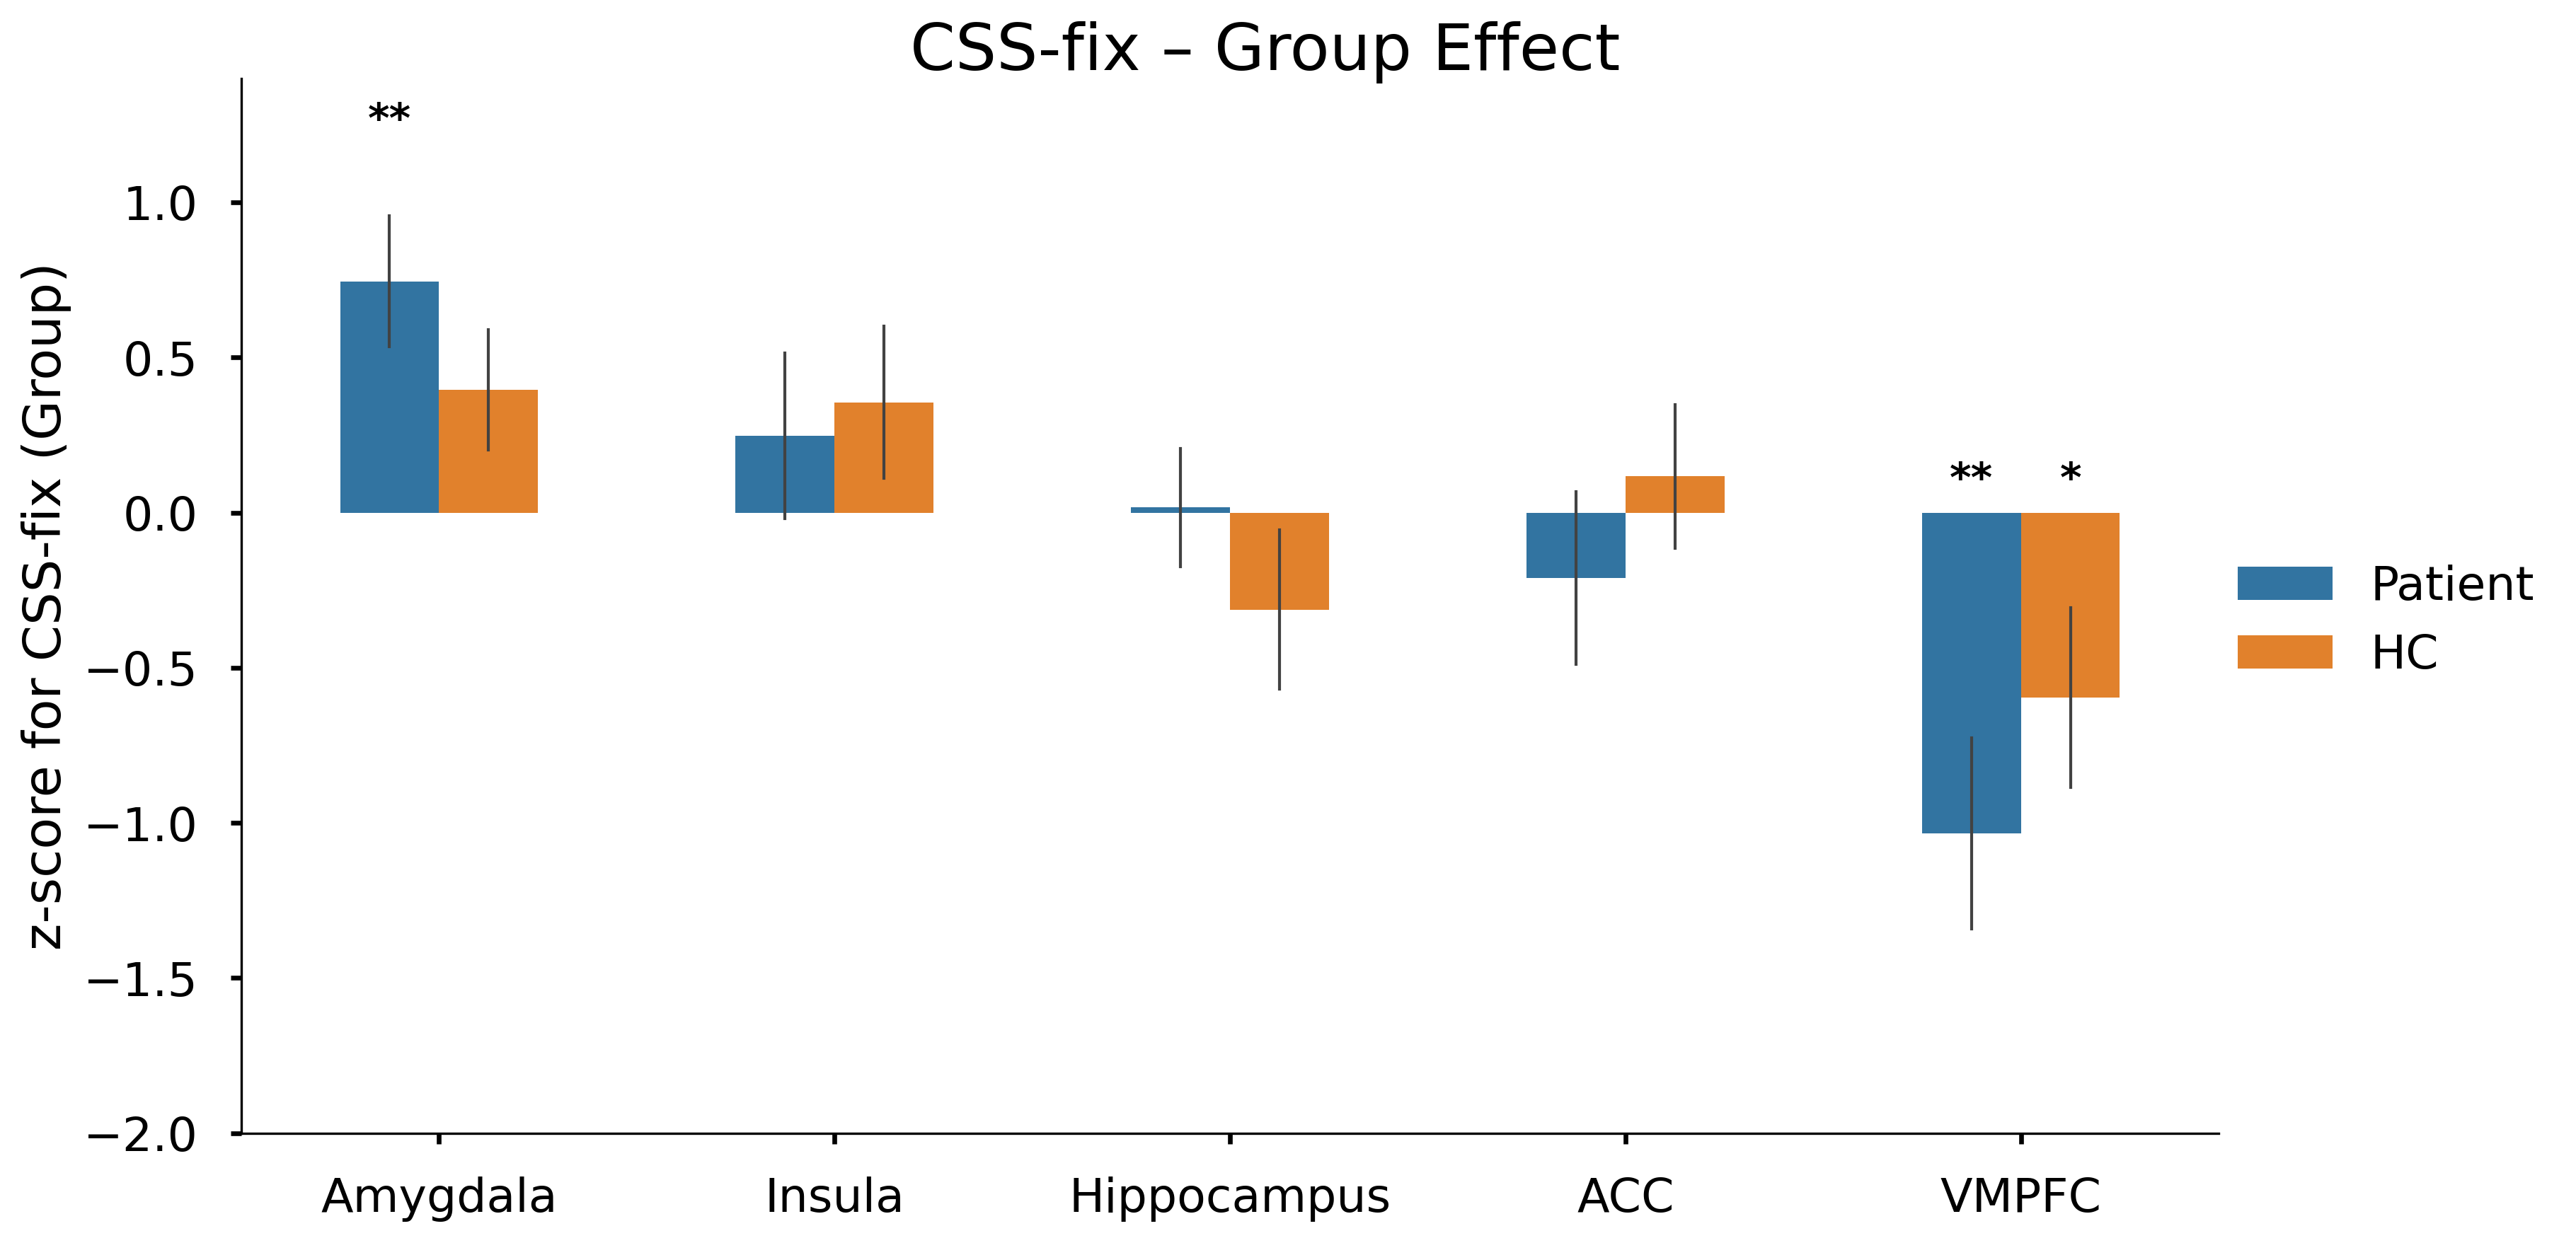


===== Group main effect: CSminus-fix =====

Model results (Z_score ~ Group + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                             0.056     0.16    46    0.875      
Insula          Group[T.HC]                                            -0.062    -0.15    46    0.880      
Hippocampus     Group[T.HC]                                            -0.130    -0.36    46    0.718      
ACC             Group[T.HC]                                            -0.053    -0.14    46    0.889      
VMPFC           Group[T.HC]                                             0.316     0.85    46    0.398      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GROUP LEVEL
ROI             Level          

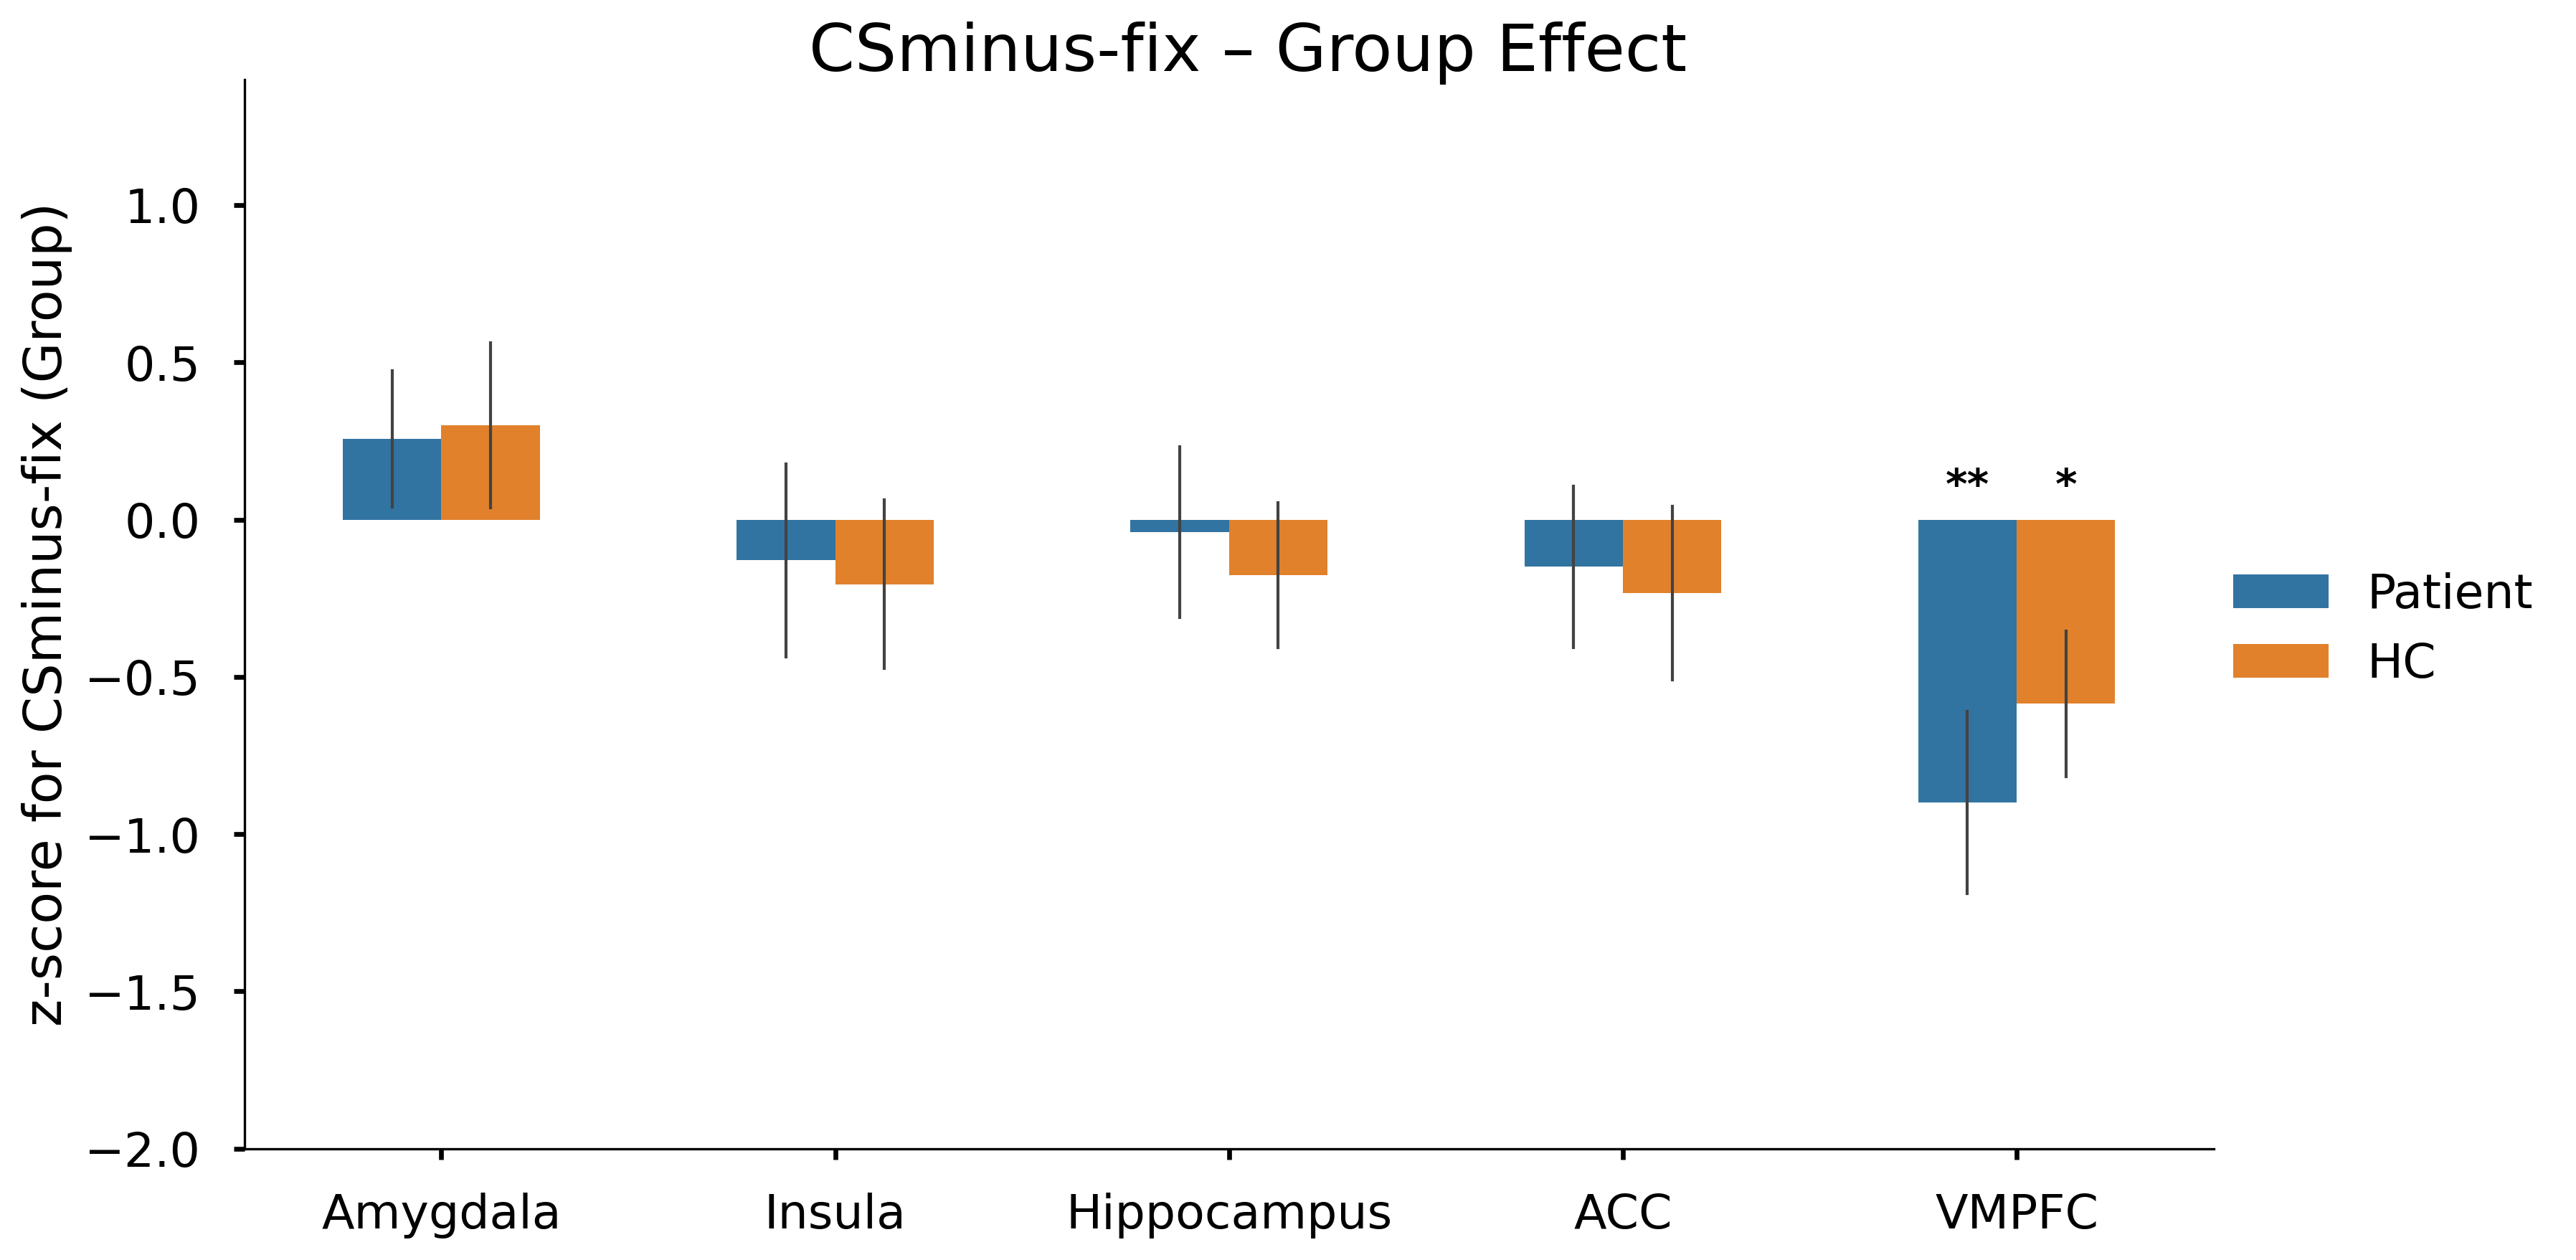

In [12]:
# 1️⃣ Group main effect
# ---------------------------------------------------------
for contrast in contrast_list:
    print(f"\n===== Group main effect: {contrast} =====")
    df = df_all.loc[(df_all['Contrast'] == contrast) & (df_all['Drug'] == 'Placebo') & (df_all['Phase'] == 'phase2')]

    g = sns.catplot(
        x='ROI', y='Z_score', hue='Group',
        order=ROI_list, hue_order=group_list,
        kind='bar', errorbar='se', 
        height=6, aspect=1.8, width=0.5, 
        err_kws={'linewidth': 1},
        data=df
    )

    ax = g.ax
    add_sig_stars(ax, df, ROI_list, get_matching_model_terms(model, "Group")[0], hue_order=group_list)


    g.set_axis_labels('', f'z-score for {contrast} (Group)')
    g.set(ylim=(-2, 1.4))
    g.legend.set_title('')
    g.figure.suptitle(f'{contrast} – Group Effect', fontsize=22, y=1.02)
    g.figure.set_dpi(300)
    plt.savefig(f'{plot_dir}/{contrast}_Group_sig.png', bbox_inches='tight')
    plt.show()


===== Gender main effect: CSR-CSS =====

Model results (Z_score ~ Gender + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Gender[T.Female]                                        0.330     1.41    97    0.162      
Insula          Gender[T.Female]                                       -0.356    -1.41    97    0.163      
Hippocampus     Gender[T.Female]                                        0.213     0.83    97    0.409      
ACC             Gender[T.Female]                                       -0.179    -0.71    97    0.482      
VMPFC           Gender[T.Female]                                        0.126     0.46    97    0.648      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GENDER LEVEL
ROI             Level           

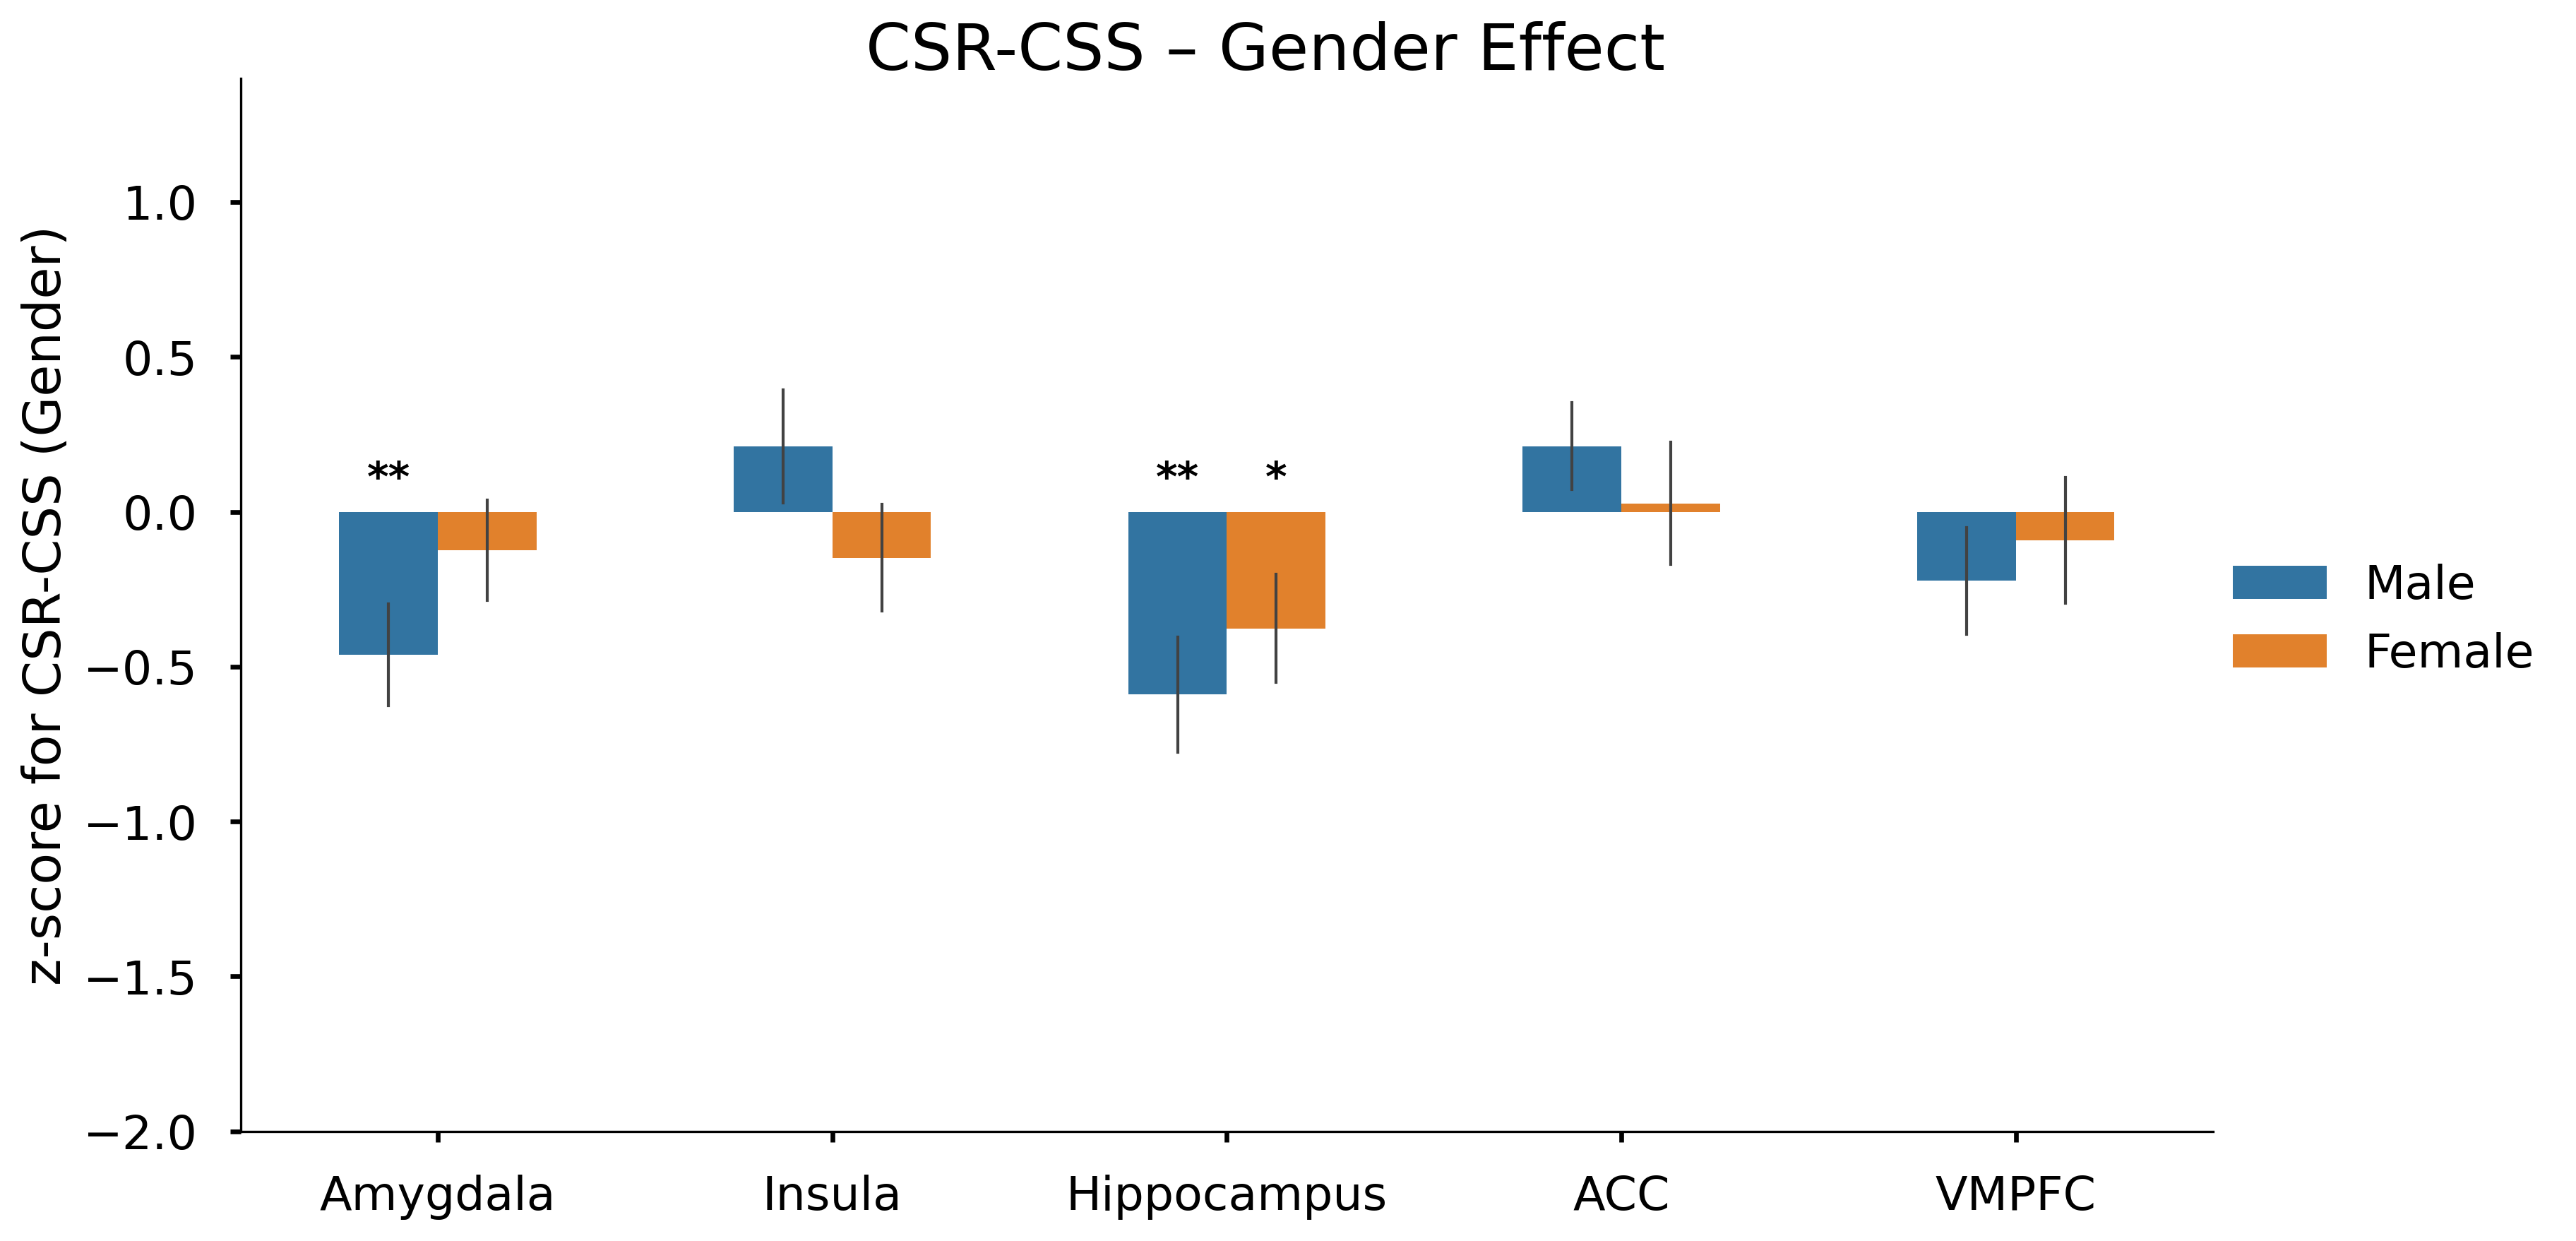


===== Gender main effect: CSR-CS- =====

Model results (Z_score ~ Gender + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Gender[T.Female]                                        0.361     1.56    97    0.121      
Insula          Gender[T.Female]                                        0.015     0.05    97    0.958      
Hippocampus     Gender[T.Female]                                        0.146     0.49    97    0.623      
ACC             Gender[T.Female]                                       -0.231    -0.81    97    0.422      
VMPFC           Gender[T.Female]                                       -0.047    -0.16    97    0.873      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GENDER LEVEL
ROI             Level           

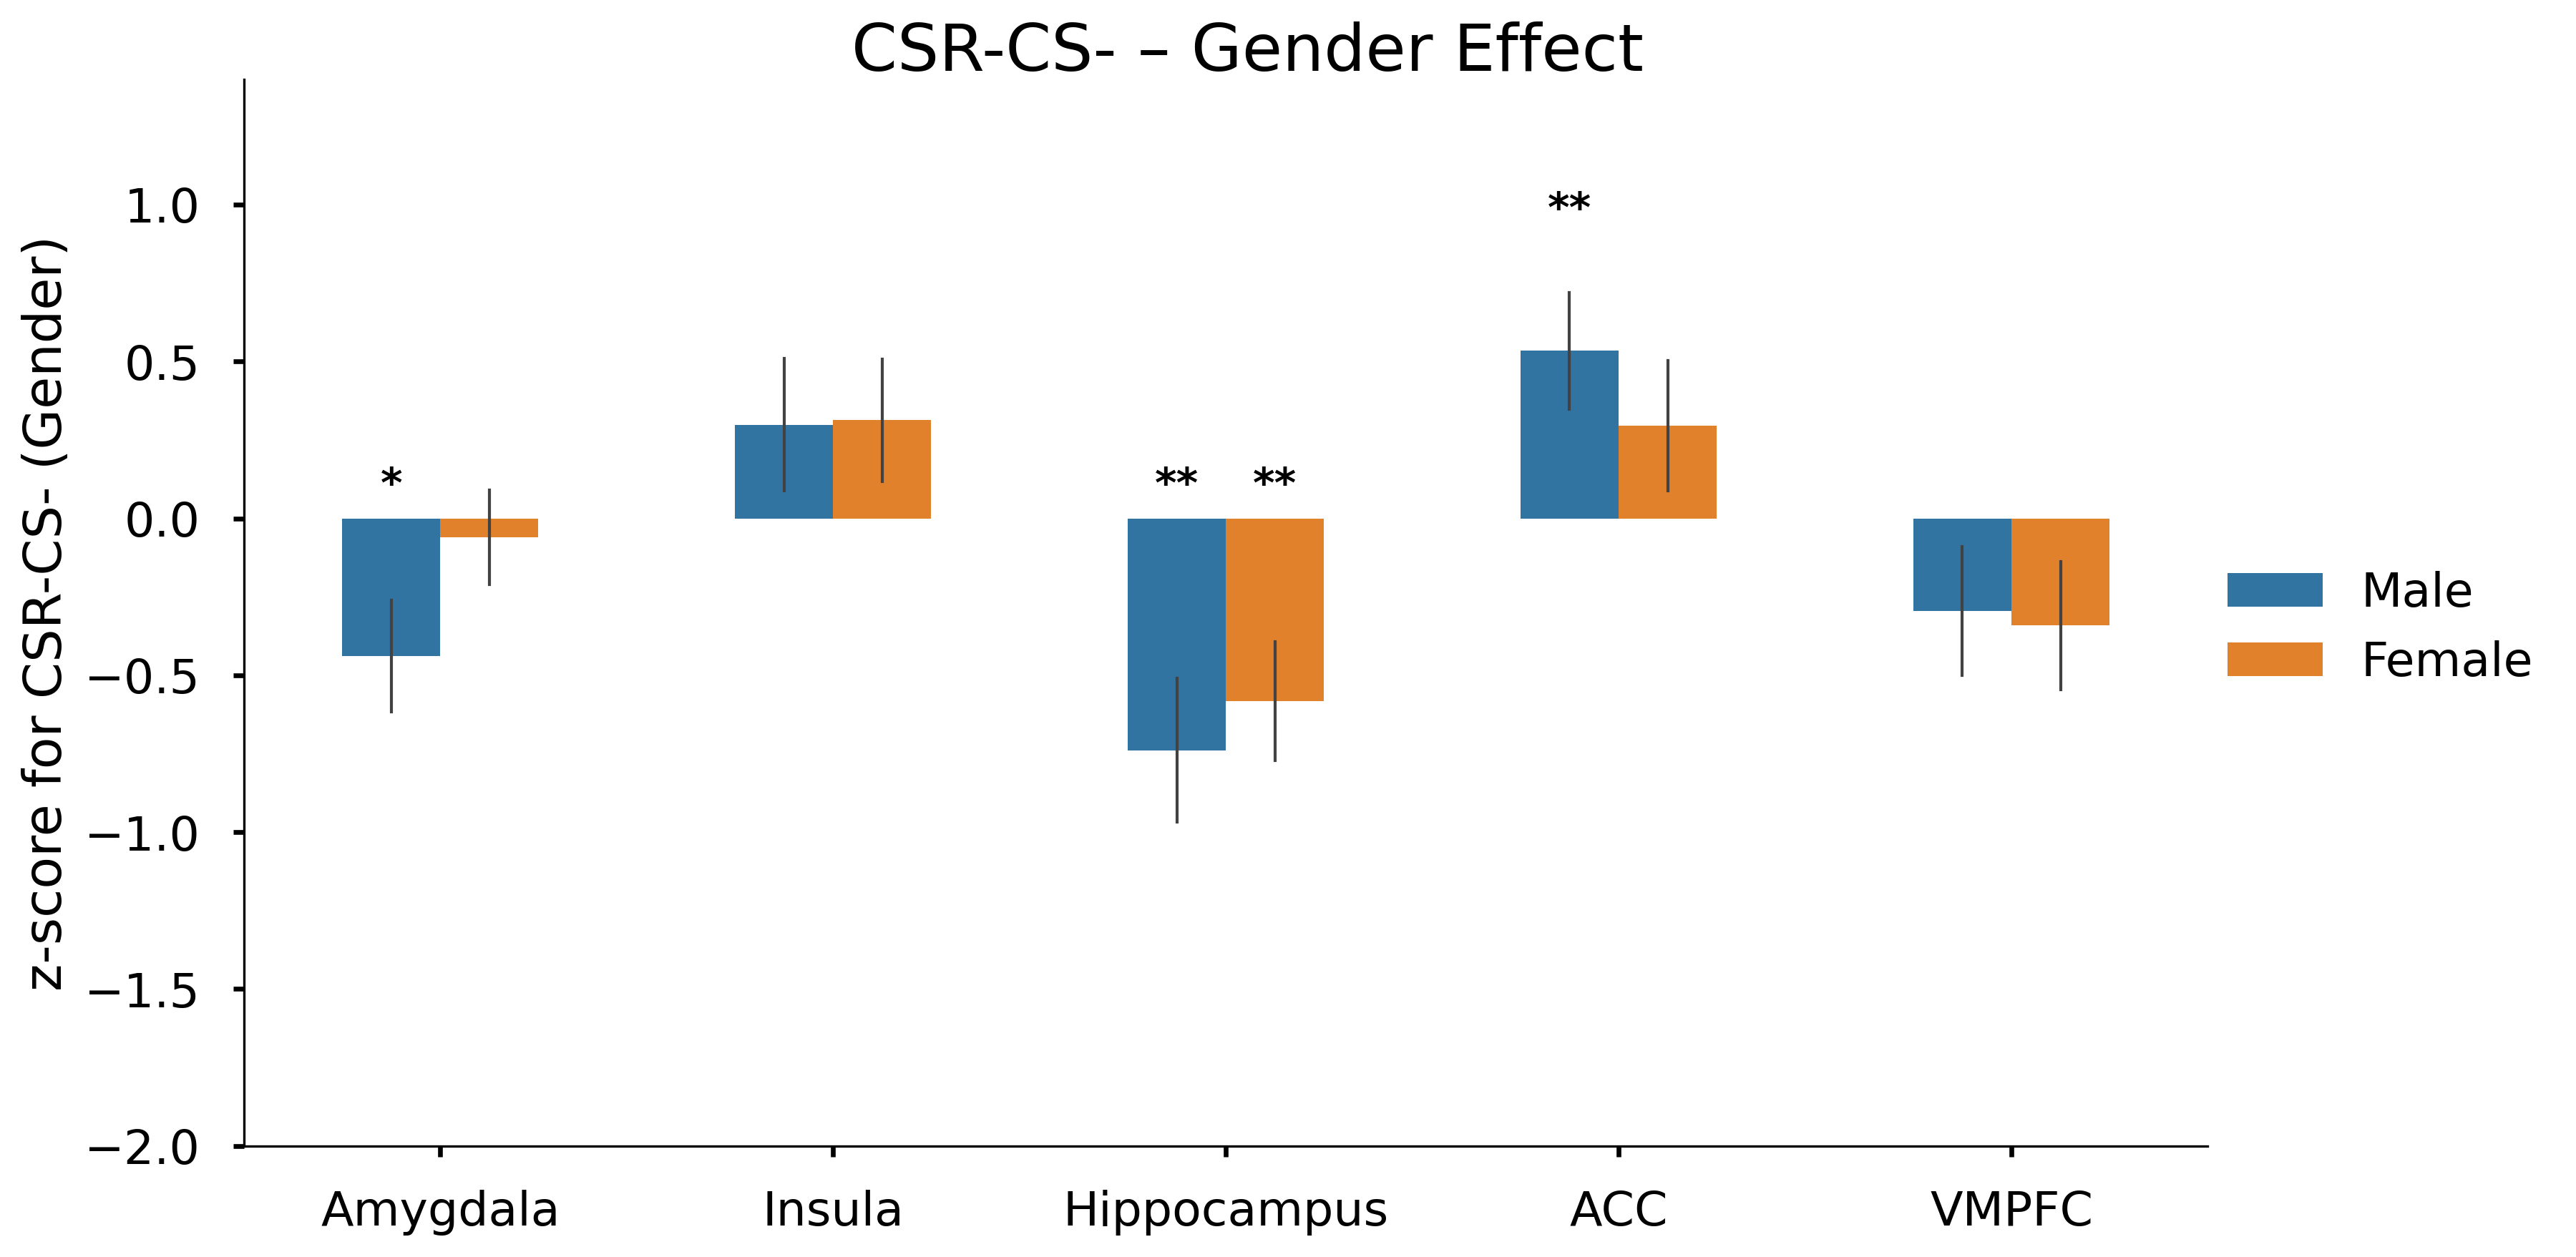


===== Gender main effect: CSS-CS- =====

Model results (Z_score ~ Gender + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Gender[T.Female]                                       -0.016    -0.07    97    0.944      
Insula          Gender[T.Female]                                        0.392     1.37    97    0.175      
Hippocampus     Gender[T.Female]                                       -0.105    -0.43    97    0.671      
ACC             Gender[T.Female]                                       -0.039    -0.14    97    0.885      
VMPFC           Gender[T.Female]                                       -0.191    -0.71    97    0.479      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GENDER LEVEL
ROI             Level           

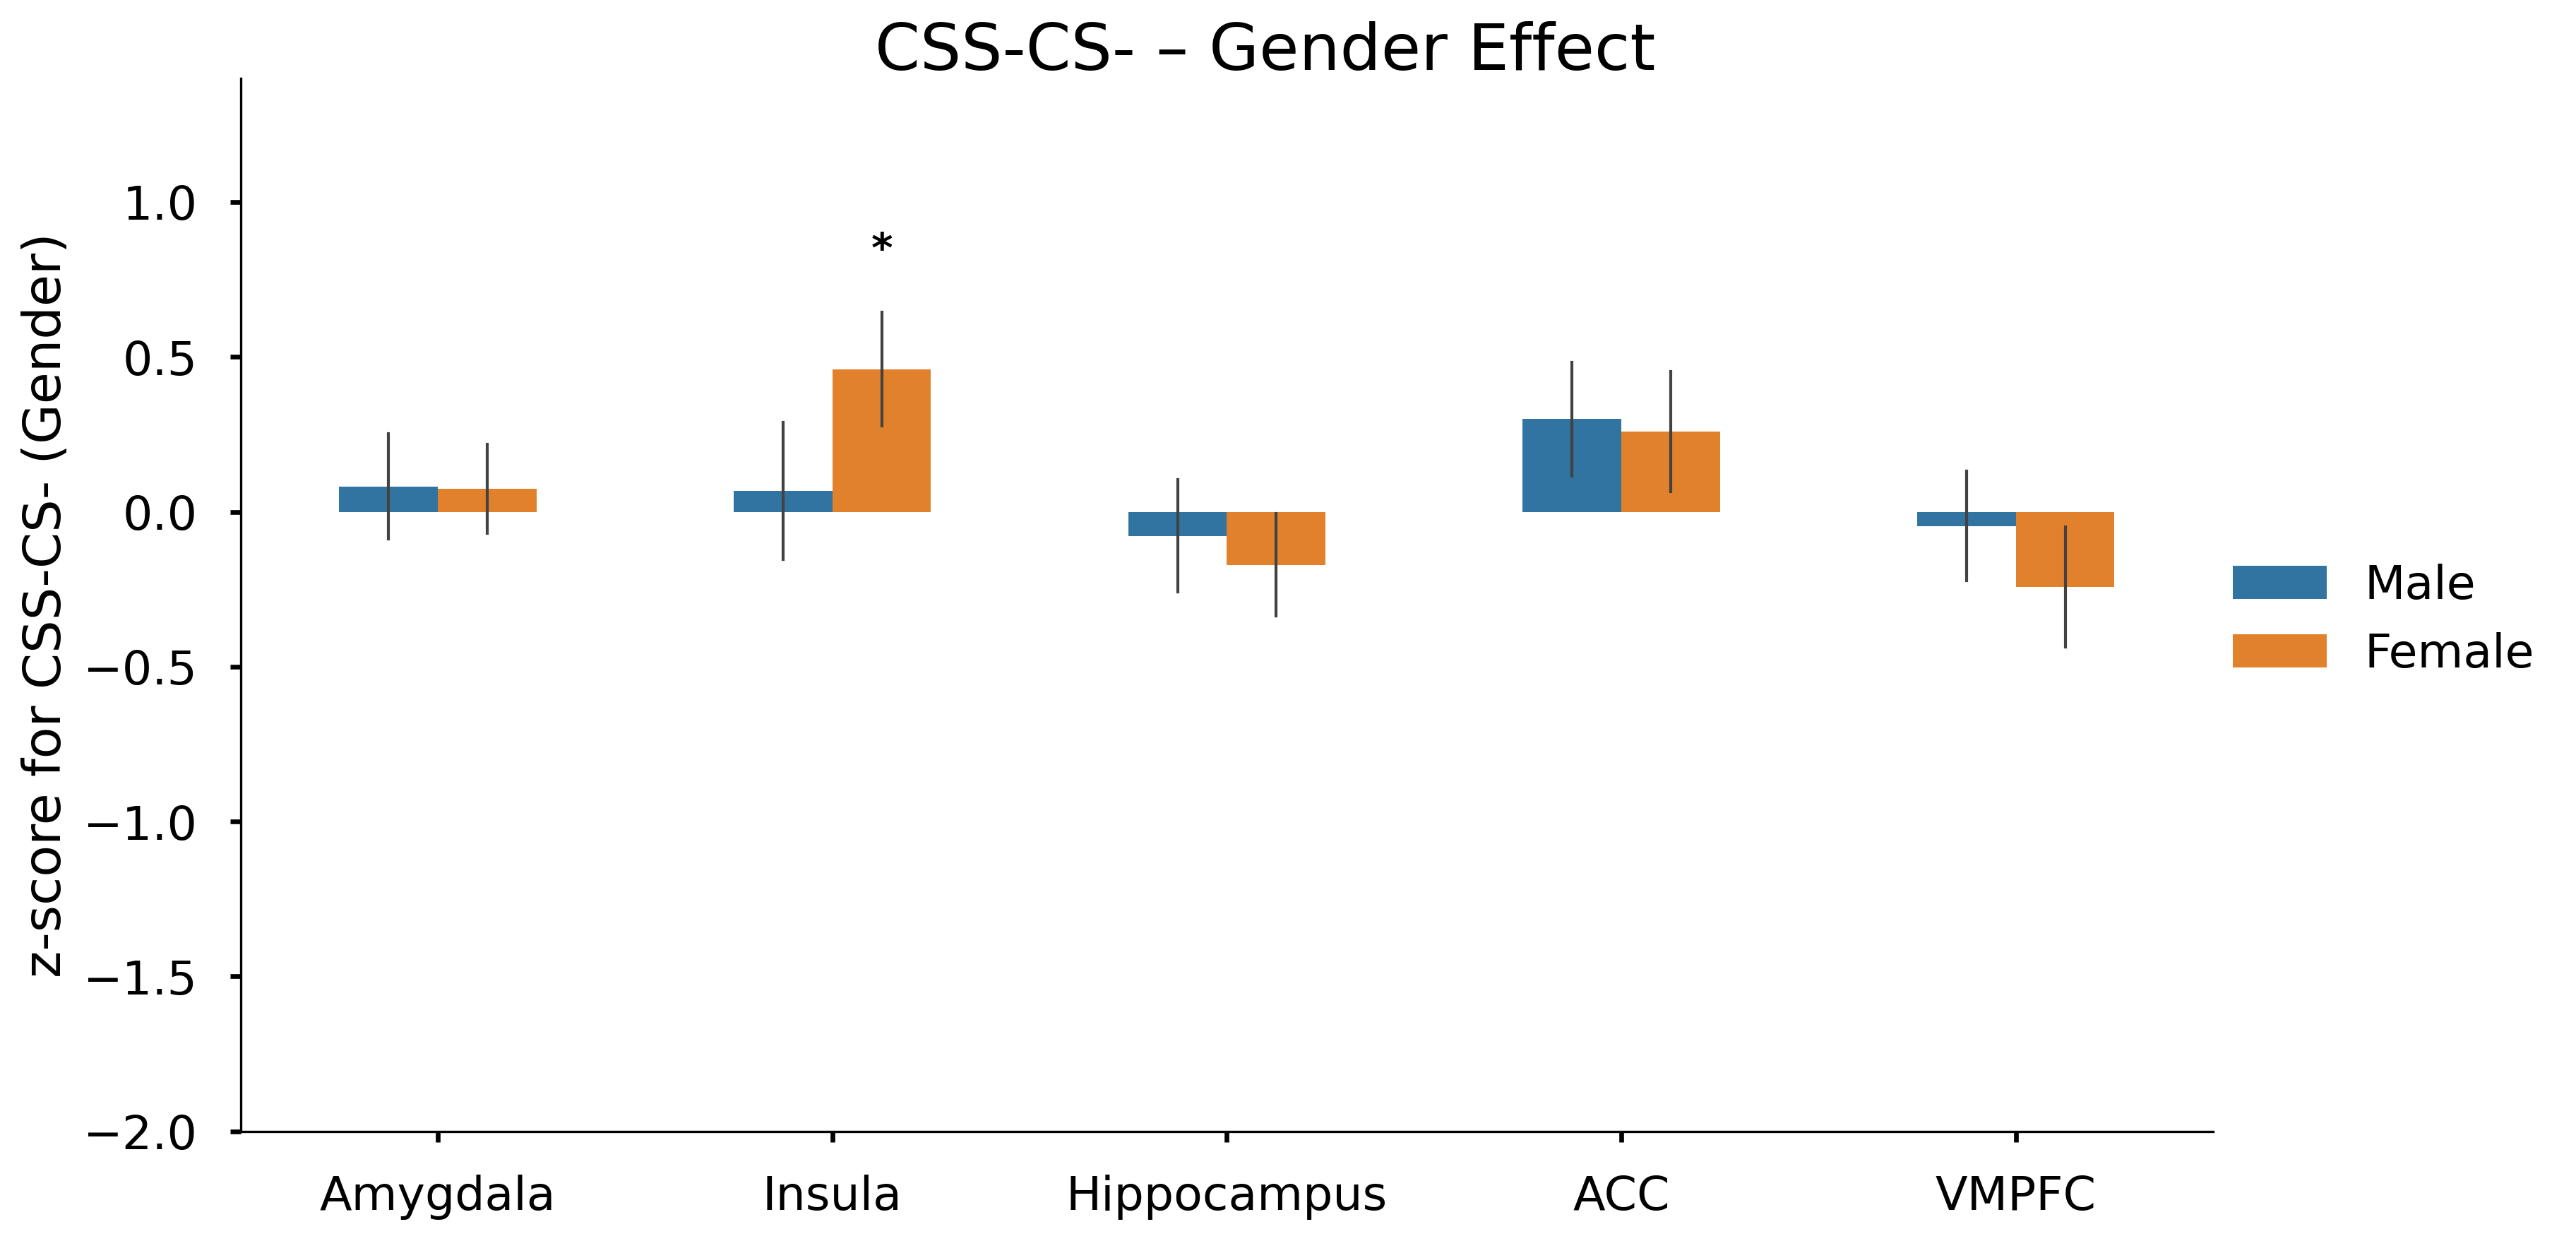


===== Gender main effect: CSR-fix =====

Model results (Z_score ~ Gender + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Gender[T.Female]                                        0.582     2.30    97    0.024     *
Insula          Gender[T.Female]                                       -0.137    -0.57    97    0.572      
Hippocampus     Gender[T.Female]                                        0.492     1.68    97    0.097      
ACC             Gender[T.Female]                                       -0.543    -1.92    97    0.058      
VMPFC           Gender[T.Female]                                        0.137     0.47    97    0.637      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GENDER LEVEL
ROI             Level           

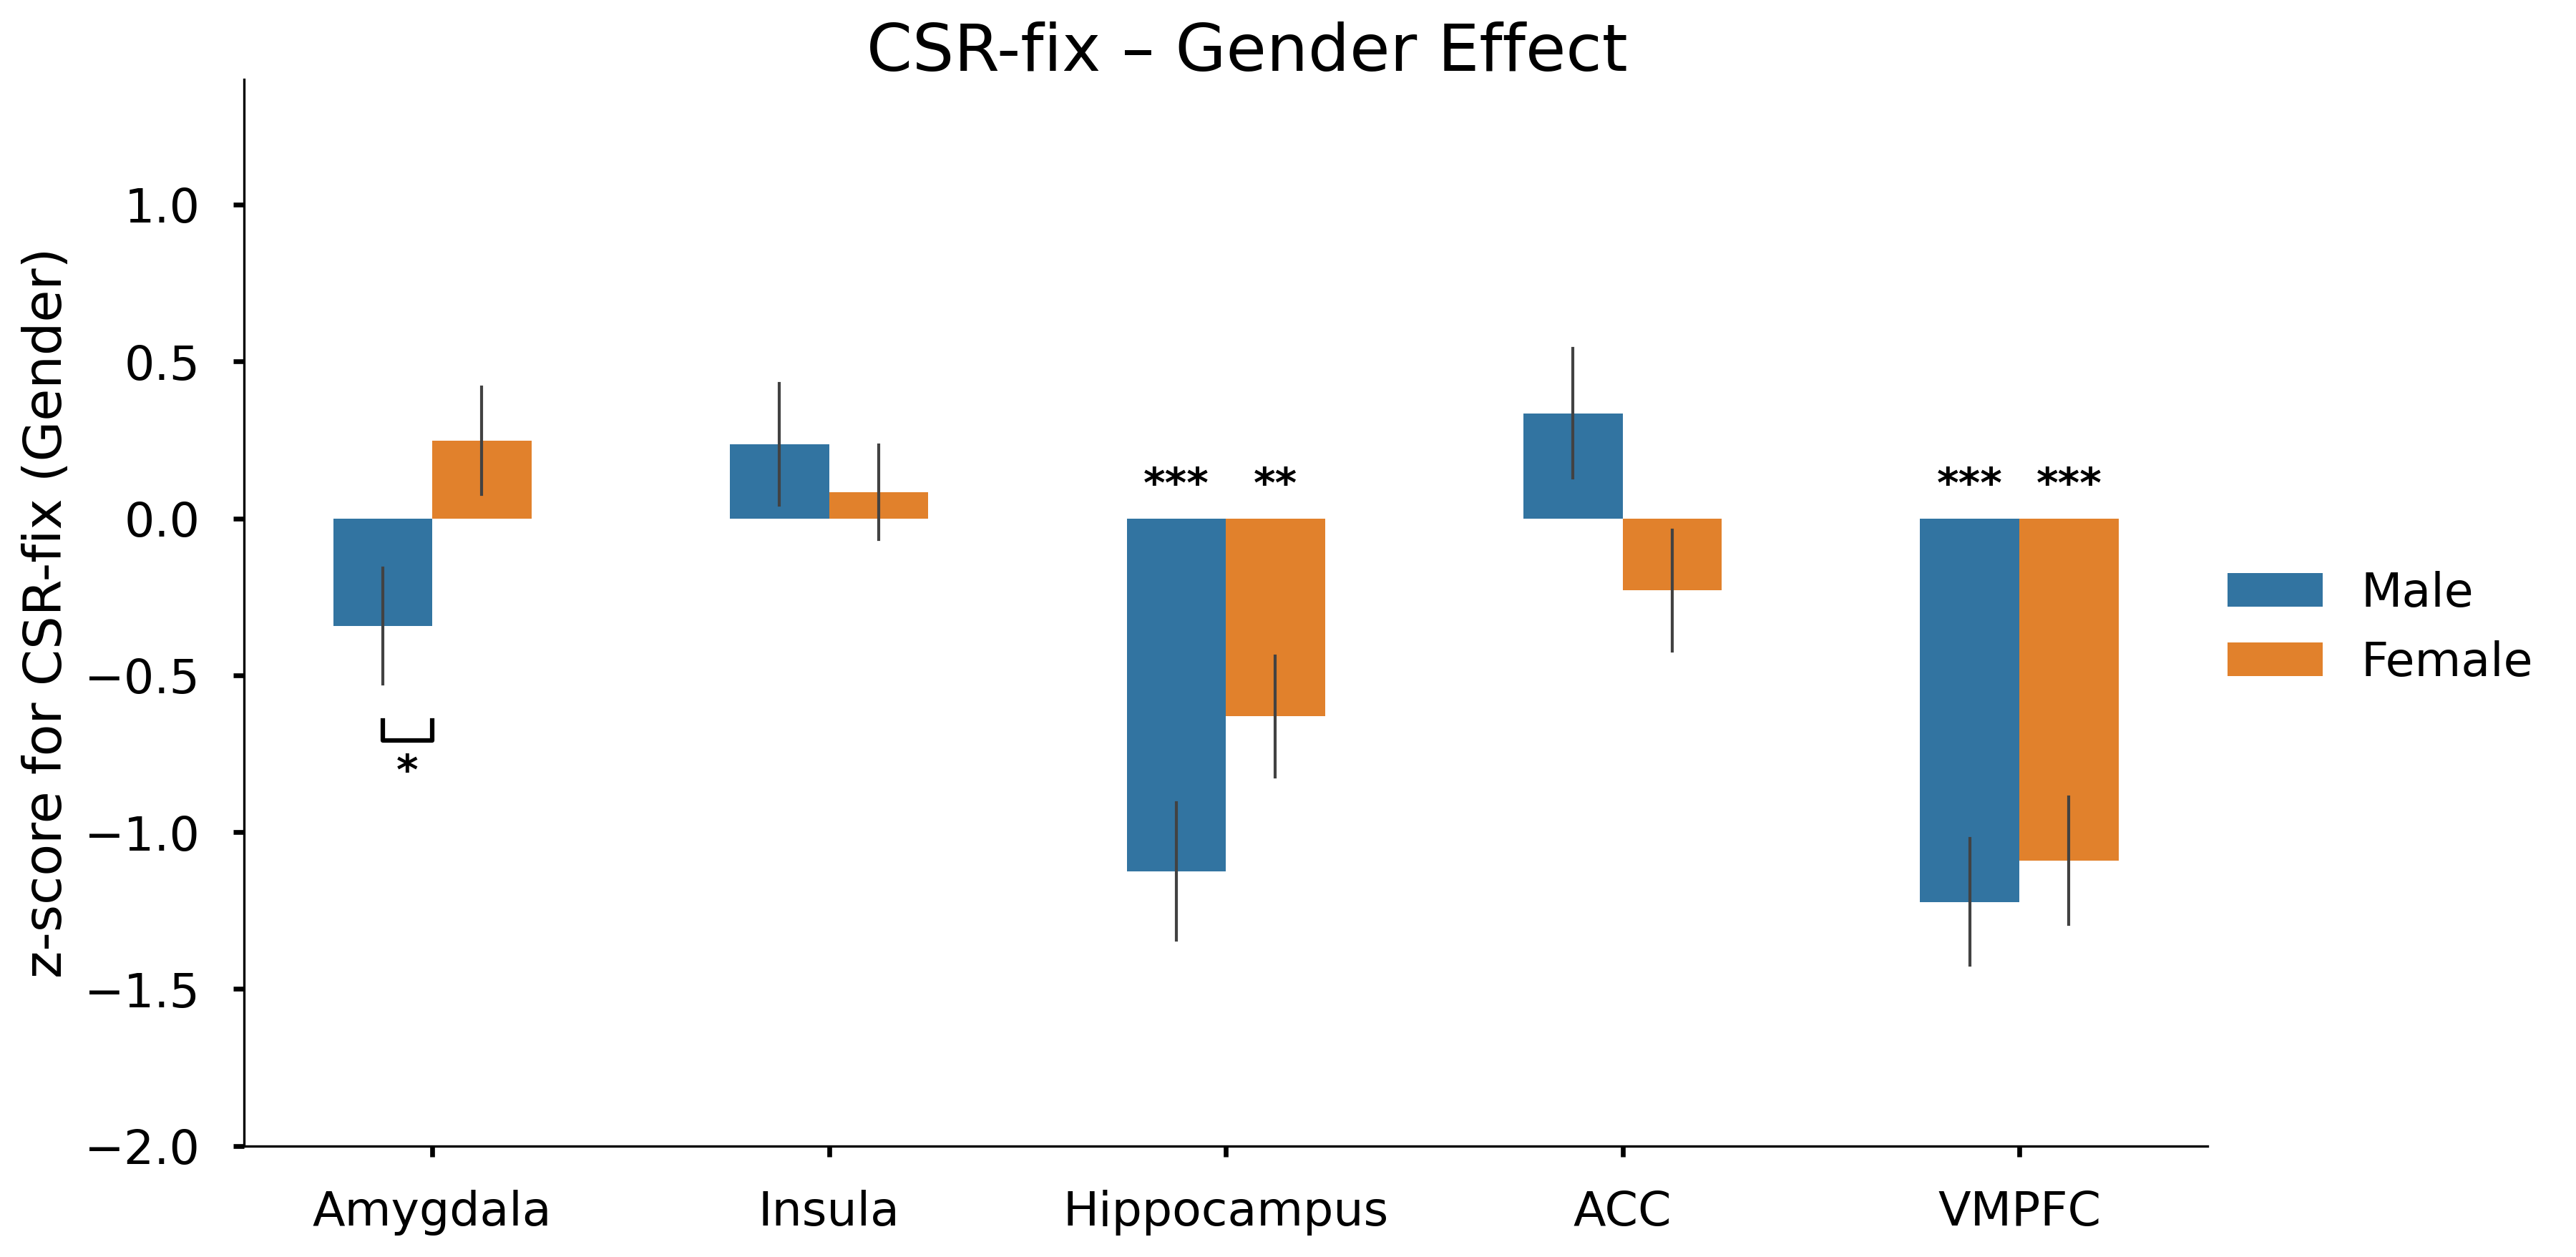


===== Gender main effect: CSS-fix =====

Model results (Z_score ~ Gender + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Gender[T.Female]                                        0.117     0.51    97    0.612      
Insula          Gender[T.Female]                                        0.343     1.35    97    0.179      
Hippocampus     Gender[T.Female]                                        0.184     0.77    97    0.445      
ACC             Gender[T.Female]                                       -0.294    -1.14    97    0.258      
VMPFC           Gender[T.Female]                                       -0.052    -0.18    97    0.858      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GENDER LEVEL
ROI             Level           

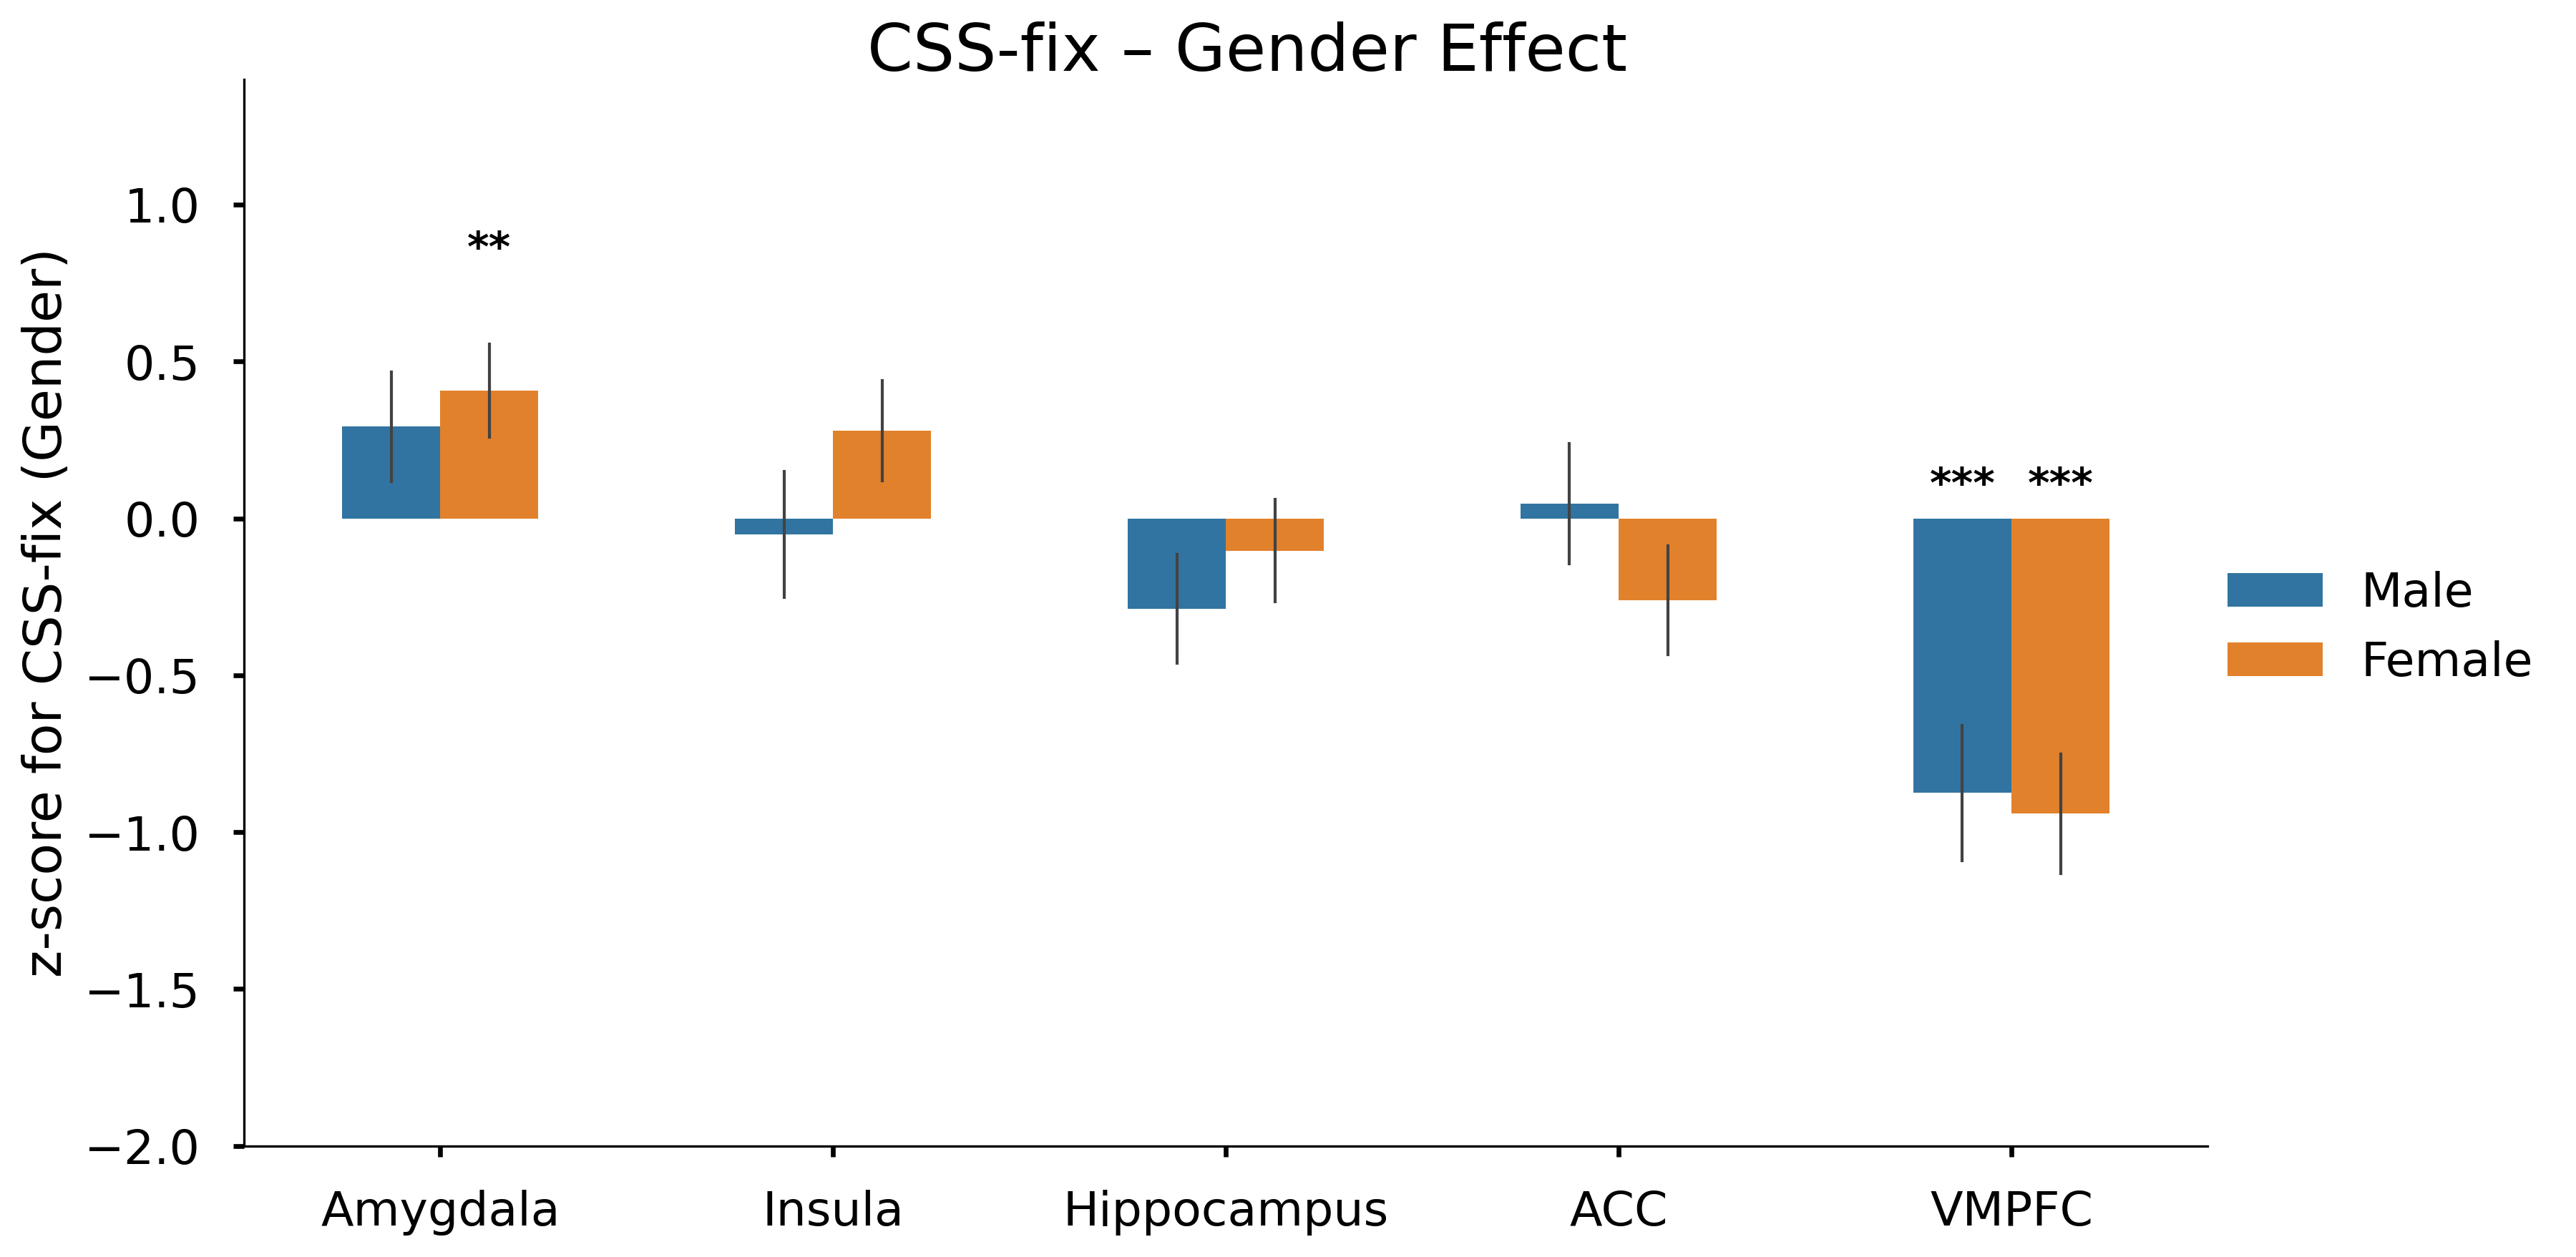


===== Gender main effect: CSminus-fix =====

Model results (Z_score ~ Gender + guess)
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Gender[T.Female]                                        0.148     0.64    97    0.521      
Insula          Gender[T.Female]                                       -0.181    -0.62    97    0.536      
Hippocampus     Gender[T.Female]                                        0.349     1.39    97    0.169      
ACC             Gender[T.Female]                                       -0.277    -0.96    97    0.340      
VMPFC           Gender[T.Female]                                        0.226     0.81    97    0.422      
----------------------------------------------------------------------------------------------------
ONE-SAMPLE T-TESTS BY GENDER LEVEL
ROI             Level       

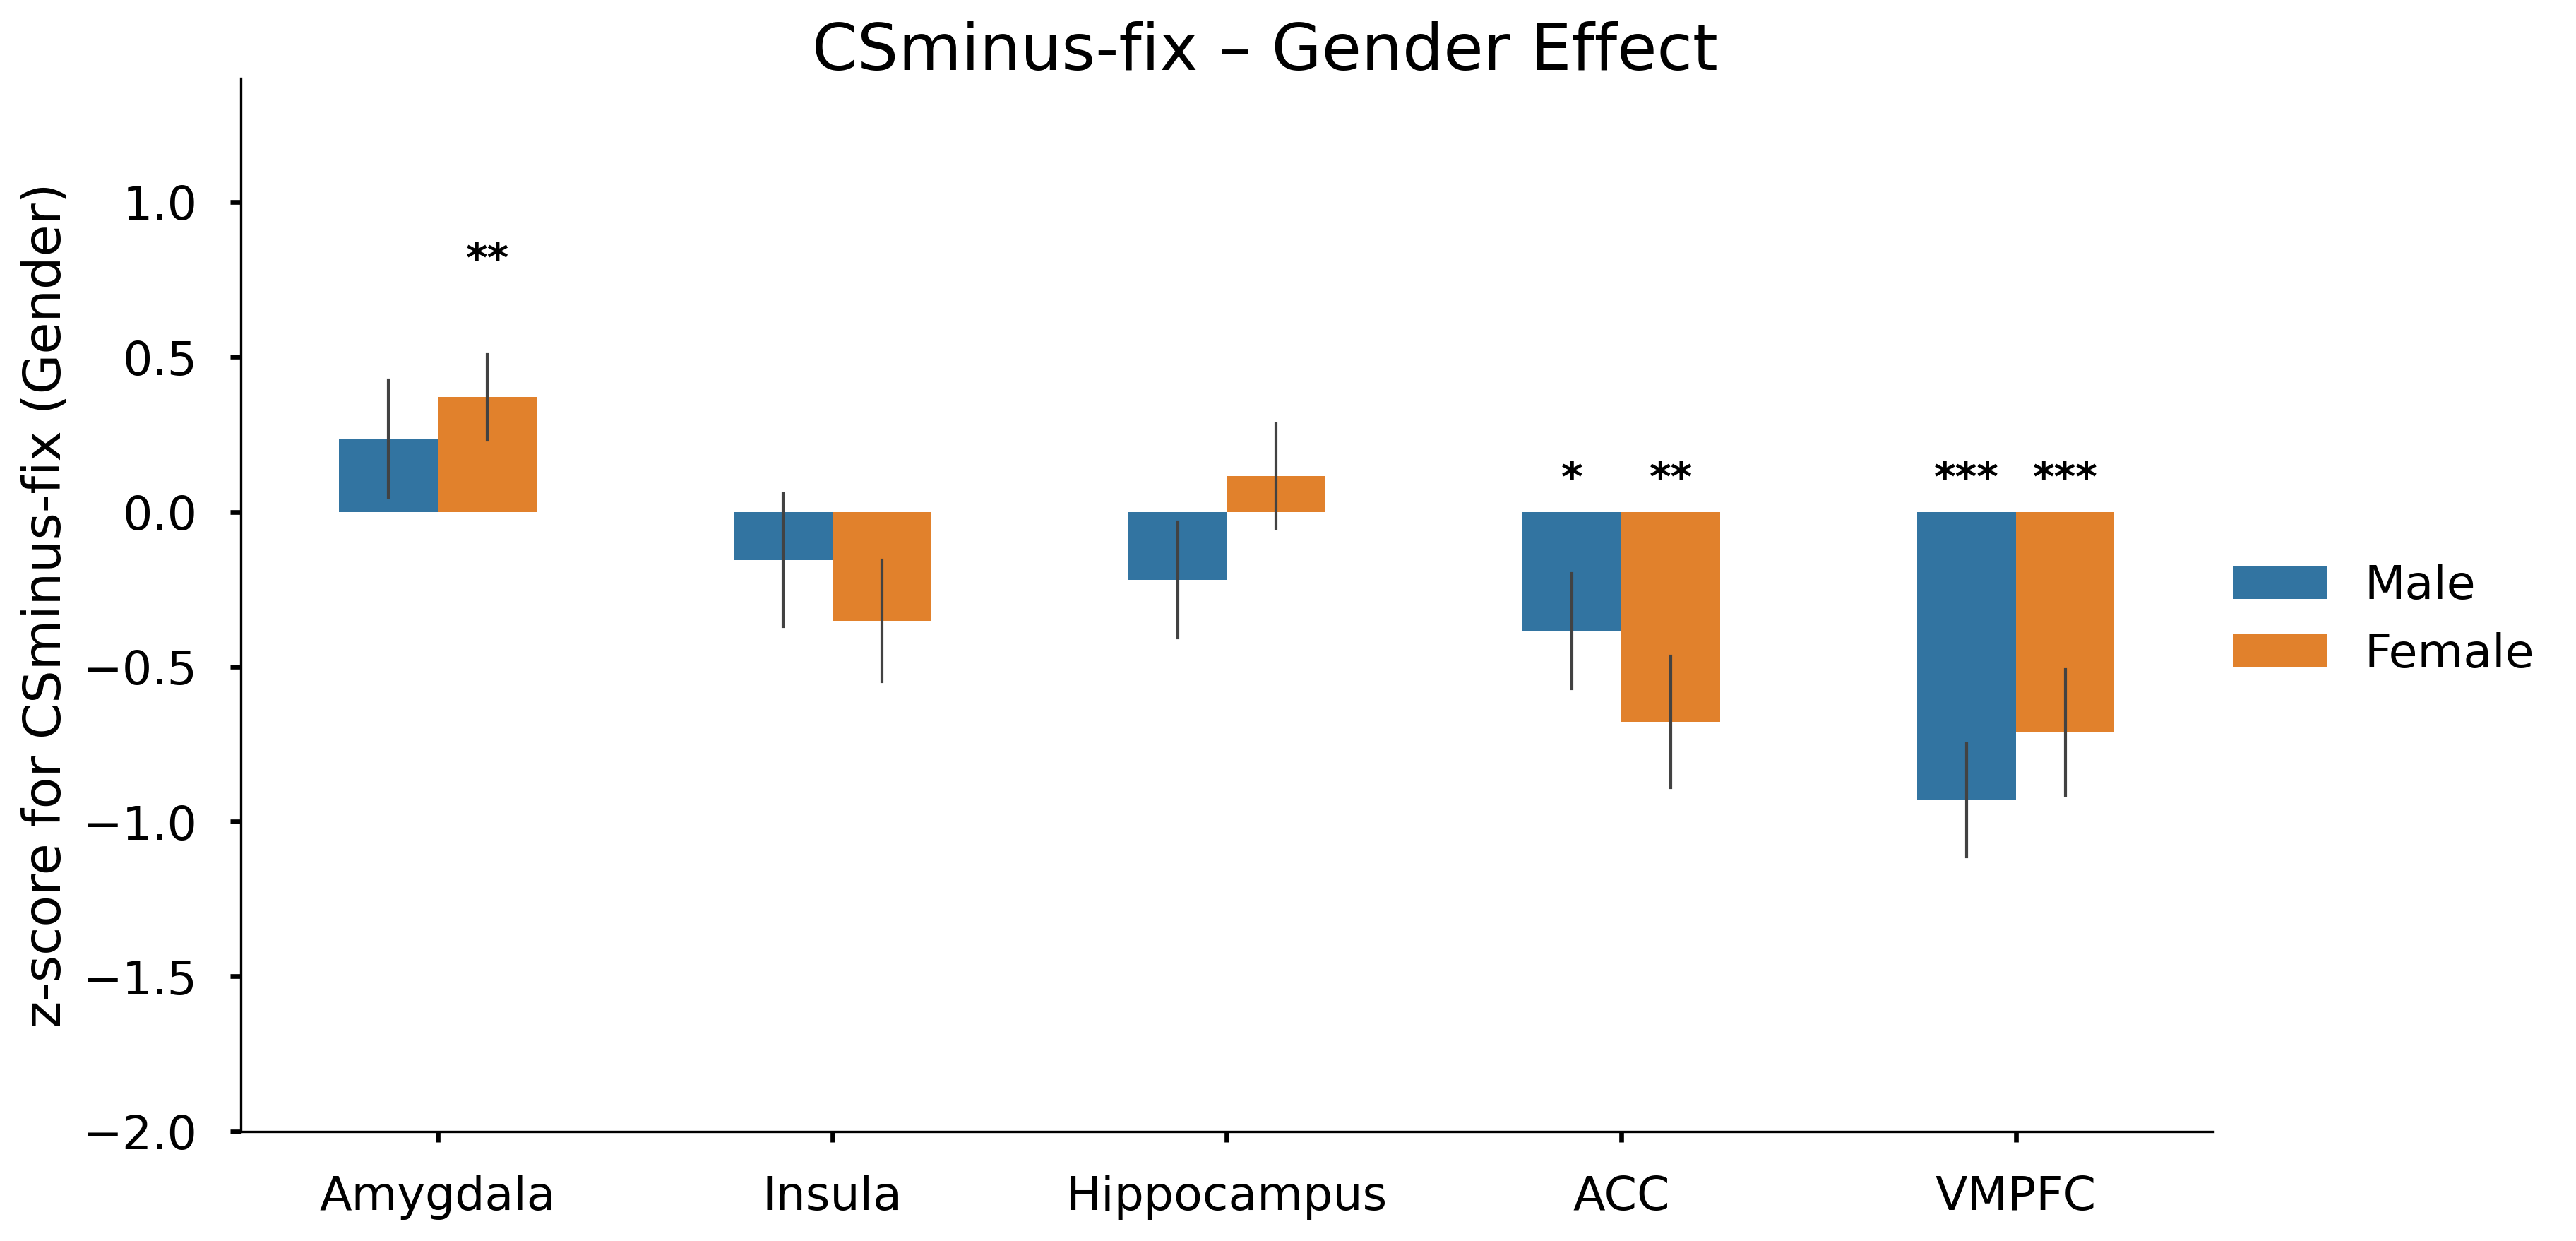

In [ ]:
# ---------------------------------------------------------
# 3️⃣ Gender main effect
# ---------------------------------------------------------
for contrast in contrast_list:
    print(f"\n===== Gender main effect: {contrast} =====")
    df = df_all.loc[(df_all['Contrast'] == contrast) & (df_all['Drug'] == 'Placebo') & (df_all['Phase'] == 'phase2')]

    g = sns.catplot(
        x='ROI', y='Z_score', hue='Gender',
        order=ROI_list, kind='bar', errorbar='se', height=6, aspect=1.8, width=0.5, 
        err_kws={'linewidth': 1},
        data=df
    )

    ax = g.ax
    add_sig_stars(ax, df, ROI_list, get_matching_model_terms(model, "Gender")[0])

    g.set_axis_labels('', f'z-score for {contrast} (Gender)')
    g.set(ylim=(-2, 1.4))
    g.legend.set_title('')
    g.figure.suptitle(f'{contrast} – Gender Effect', fontsize=22, y=1.02)
    g.figure.set_dpi(300)
    plt.savefig(f'{plot_dir}/{contrast}_Gender_sig.png', bbox_inches='tight')
    plt.show()

In [ ]:
interaction_terms = get_matching_model_terms(model, "two_way")

for term in interaction_terms:
    var1, var2 = extract_factors_from_term(term)
    for contrast in contrast_list:
        print(f"\n===== {var1} × {var2} interaction: {contrast} =====")
        df = df_all.loc[(df_all['Contrast'] == contrast) & (df_all['Drug'] == 'Placebo') & (df_all['Phase'] == 'phase2')]

        g = sns.catplot(
            x='ROI', y='Z_score', hue=var1, col=var2,
            order=ROI_list,
            kind='bar', errorbar='se',
            height=6, aspect=1.6, width=0.5,
            err_kws={'linewidth': 1},
            data=df
        )

        for ax in g.axes.flat:
            add_sig_stars(ax, df, ROI_list, term)

        g.set_axis_labels('', f'z-score for {contrast} ({var1} × {var2})')
        g.set(ylim=(-2, 1.4))
        g.legend.set_title('')
        g.figure.suptitle(f'{contrast} – {var1} × {var2} Interaction', fontsize=22, y=1.02)
        g.figure.set_dpi(300)
        plt.savefig(f'{plot_dir}/{contrast}_{var1}_{var2}_interaction_sig.png', bbox_inches='tight')
        plt.show()

        #line plots
        g = sns.catplot(
            data=df,
            x=var1, y='Z_score', hue=var2,
            col='ROI',
            kind='point',         # line plot (mean + SE)
            errorbar='se',        # ✅ correct for seaborn ≥0.12
            dodge=True,
            markers=['o', 's'],
            linestyles=['-', '--'],
            height=6, aspect=1.2
        )
        add_sig_stars_lineplot_interaction(
            g.axes, df, ROI_list, term
        )
        #g.set_axis_labels('', f'z-score for {contrast} ({var1} × {var2})')
        g.set(ylim=(-2, 1.4))
        g.legend.set_title('')
        g.figure.suptitle(f'{contrast} – {var1} × {var2} Interaction', fontsize=22, y=1.02)
        g.figure.set_dpi(300)
        plt.savefig(f'{plot_dir}/line_{contrast}_{var1}_{var2}_interaction_sig.png', bbox_inches='tight')
        plt.show()

In [ ]:

formula = "Z_score ~ Group + Gender + guess"

for contrast in contrast_list:
        df = df_all.loc[(df_all['Contrast'] == contrast) & (df_all['Drug'] == 'Placebo') & (df_all['Phase'] == 'phase2')]

        print(f"\nModel results ({formula}) in {contrast}")
        print(f"{'ROI':<15} {'Variable':<50} {'β':>10} {'t':>8} {'df':>5} {'p':>8} {'Sig':>5}")
        print("-" * 100)

        # === Table 1: Model results ===
        for i, roi in enumerate(ROI_list):
            df_roi = df[df["ROI"] == roi]
            if len(df_roi) < 4:
                continue
            model = smf.ols(formula, data=df_roi).fit()
            dfree = int(model.df_resid)

            # Extract and print all terms except intercept
            for term in model.params.index:
                if term.lower() == "intercept":
                    continue

                beta = model.params[term]
                tval = model.tvalues[term]
                pval = model.pvalues[term]
                star = significance_marker(pval)

                print(f"{roi:<15} {term:<50} {beta:>10.3f} {tval:>8.2f} "
                    f"{dfree:>5} {pval:>10.4f} {star:>5}")

        print("-" * 100)
    


Model results (Z_score ~ Group + Gender + guess) in CSR-CSS
ROI             Variable                                                    β        t    df        p   Sig
----------------------------------------------------------------------------------------------------
Amygdala        Group[T.HC]                                             0.182     0.78    96     0.4391      
Amygdala        Gender[T.Female]                                        0.344     1.46    96     0.1464      
Amygdala        guess[T.1.0]                                           -0.161    -0.67    96     0.5064      
Insula          Group[T.HC]                                            -0.058    -0.23    96     0.8208      
Insula          Gender[T.Female]                                       -0.361    -1.41    96     0.1606      
Insula          guess[T.1.0]                                            0.052     0.20    96     0.8422      
Hippocampus     Group[T.HC]                                           